# Allocazione Dinamica delle Strategie - Momentum Strategy

## Obiettivo
Implementare un sistema di allocazione dinamica che:
- **Favorisce** le strategie che stanno performando bene
- **Penalizza** quelle che stanno performando male  
- **Ribilancia** ogni lunedì
- Testa diverse combinazioni per trovare l'allocazione ottimale

## Metodologie da Esplorare
1. **Momentum Puro**: Allocazione basata su performance recente
2. **Risk-Adjusted Momentum**: Momentum aggiustato per il rischio
3. **Momentum con Volatility Scaling**: Allocazione che considera la volatilità
4. **Momentum Ranking**: Top N strategie ricevono più capitale
5. **Momentum Smooth**: Transizioni graduali per ridurre il turnover

## Metriche di Valutazione
- Sharpe Ratio del portafoglio
- Maximum Drawdown
- Calmar Ratio  
- Turnover del portafoglio
- Stabilità delle allocazioni

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from pathlib import Path
import glob
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')

print("🚀 Librerie importate con successo!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔢 Numpy version: {np.__version__}")

🚀 Librerie importate con successo!
📊 Pandas version: 2.3.0
🔢 Numpy version: 2.2.6


In [3]:
# 🚀 OTTIMIZZAZIONI PER PERFORMANCE
# =================================
# Queste ottimizzazioni migliorano significativamente la velocità di esecuzione

# 1. Configurazione NumPy per performance
import os
os.environ['NUMEXPR_MAX_THREADS'] = '8'  # Usa tutti i core disponibili
os.environ['OPENBLAS_NUM_THREADS'] = '8'

# 2. Importazioni ottimizzate
import numba
from numba import jit, njit
from functools import lru_cache
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

# 3. Configurazione pandas per performance
pd.set_option('mode.chained_assignment', None)  # Evita warning che rallentano
pd.set_option('compute.use_bottleneck', True)   # Usa bottleneck per speed-up
pd.set_option('compute.use_numexpr', True)      # Usa numexpr per expressions

print("⚡ Ottimizzazioni performance attivate!")
print(f"🔧 Core disponibili: {mp.cpu_count()}")
print(f"📊 Pandas versione: {pd.__version__}")
print(f"🚀 NumPy versione: {np.__version__}")

# 4. Configurazione cache per operazioni ripetitive
import functools
from datetime import datetime

# Cache per evitare di ricaricare i dati
@lru_cache(maxsize=128)
def cached_datetime_parse(date_string):
    """Cache per parsing datetime"""
    return pd.to_datetime(date_string, format='%Y.%m.%d %H:%M')

print("✅ Cache e ottimizzazioni configurate!")

⚡ Ottimizzazioni performance attivate!
🔧 Core disponibili: 16
📊 Pandas versione: 2.3.0
🚀 NumPy versione: 2.2.6
✅ Cache e ottimizzazioni configurate!


## ⚙️ Configurazione Universale

**IMPORTANTE**: Modifica questi parametri per adattare il notebook ai tuoi dati e test specifici:

In [4]:
# ⚙️ CONFIGURAZIONE UNIVERSALE DEL NOTEBOOK
# ==============================================
# Modifica questi parametri per adattare l'analisi ai tuoi dati

print("🔧 CONFIGURAZIONE NOTEBOOK - ALLOCAZIONE DINAMICA")
print("=" * 55)

# ===== PERCORSI E DATI =====
# Percorso principale dove cercare i file CSV (cerca anche nelle sottocartelle)
DATA_BASE_PATH = '/home/edocame/Desktop/bollingerBands/notebooks/DATA'

# Pattern di ricerca file CSV (supporta wildcards)
CSV_FILE_PATTERN = '*.csv'

# Filtro temporale (inizio analisi)
START_DATE = '2024-01-01'  # Formato: 'YYYY-MM-DD'

print(f"📁 Percorso dati: {DATA_BASE_PATH}")
print(f"🔍 Pattern file: {CSV_FILE_PATTERN}")
print(f"📅 Data inizio: {START_DATE}")

# ===== PARAMETRI ALLOCAZIONE =====
# Lookback window per i test singoli (giorni)
DEFAULT_LOOKBACK_WINDOW = 30

# Strategie da testare (puoi commentare/decommentare quelle che vuoi)
STRATEGIES_TO_TEST = [
    ('momentum_pure', 'Momentum Puro', {}),
    ('momentum_risk_adjusted', 'Momentum Risk-Adjusted (Sharpe)', {}),
    ('momentum_ranking', 'Top 3 Strategie (Ranking)', {'top_n': 3}),
    ('momentum_volatility_scaled', 'Momentum + Volatility Scaling', {}),
]

print(f"⏱️ Lookback window default: {DEFAULT_LOOKBACK_WINDOW} giorni")
print(f"🎯 Strategie da testare: {len(STRATEGIES_TO_TEST)}")

# ===== OTTIMIZZAZIONE PARAMETRI =====
# Range di lookback window da testare nell'ottimizzazione
OPTIMIZATION_LOOKBACK_RANGE = [15, 30, 45, 60, 90, 120]

# Range di top_n per le strategie ranking
OPTIMIZATION_TOP_N_RANGE = [1, 2, 3, 4]

# Abilita/disabilita ottimizzazione (per test veloci)
ENABLE_OPTIMIZATION = True

print(f"🔬 Ottimizzazione lookback: {OPTIMIZATION_LOOKBACK_RANGE}")
print(f"🏆 Ottimizzazione top_n: {OPTIMIZATION_TOP_N_RANGE}")
print(f"⚡ Ottimizzazione abilitata: {ENABLE_OPTIMIZATION}")

# ===== PARAMETRI GRAFICI =====
# Dimensioni figure matplotlib
FIGURE_SIZE = (15, 10)

# Stile grafici
PLOT_STYLE = 'seaborn-v0_8'

# Dimensione font
FONT_SIZE = 10

# Set up plotting parameters (dalla configurazione)
plt.style.use(PLOT_STYLE)
plt.rcParams['figure.figsize'] = FIGURE_SIZE
plt.rcParams['font.size'] = FONT_SIZE


print(f"📊 Dimensioni grafici: {FIGURE_SIZE}")
print(f"🎨 Stile grafici: {PLOT_STYLE}")

# ===== PARAMETRI AVANZATI =====
# Frequenza di resampling per sincronizzazione
RESAMPLE_FREQUENCY = '1H'  # '1H', '30T', '15T', '5T', '1T'

# Minimum data points richiesti per strategia
MIN_DATA_POINTS = 10

# Encoding da provare per i file CSV
CSV_ENCODINGS = ['utf-8', 'utf-16', 'latin-1', 'cp1252', 'iso-8859-1']

print(f"⏰ Frequenza resampling: {RESAMPLE_FREQUENCY}")
print(f"📊 Punti dati minimi: {MIN_DATA_POINTS}")

# ===== VALIDAZIONE CONFIGURAZIONE =====
from pathlib import Path

config_data_path = Path(DATA_BASE_PATH)
if not config_data_path.exists():
    print(f"⚠️ ATTENZIONE: Il percorso {DATA_BASE_PATH} non esiste!")
    print("📝 Modifica la variabile DATA_BASE_PATH nella cella di configurazione")
else:
    csv_files_found = list(config_data_path.rglob(CSV_FILE_PATTERN))
    print(f"✅ Trovati {len(csv_files_found)} file CSV nel percorso specificato")
    
    if len(csv_files_found) == 0:
        print("⚠️ ATTENZIONE: Nessun file CSV trovato!")
        print("📝 Verifica il percorso e il pattern di ricerca")

print(f"\n🚀 Configurazione completata! Procedi con l'esecuzione delle celle successive.")
print(f"💡 TIP: Modifica questa cella per personalizzare l'analisi prima di eseguire il resto del notebook.")

🔧 CONFIGURAZIONE NOTEBOOK - ALLOCAZIONE DINAMICA
📁 Percorso dati: /home/edocame/Desktop/bollingerBands/notebooks/DATA
🔍 Pattern file: *.csv
📅 Data inizio: 2024-01-01
⏱️ Lookback window default: 30 giorni
🎯 Strategie da testare: 4
🔬 Ottimizzazione lookback: [15, 30, 45, 60, 90, 120]
🏆 Ottimizzazione top_n: [1, 2, 3, 4]
⚡ Ottimizzazione abilitata: True
📊 Dimensioni grafici: (15, 10)
🎨 Stile grafici: seaborn-v0_8
⏰ Frequenza resampling: 1H
📊 Punti dati minimi: 10
✅ Trovati 12 file CSV nel percorso specificato

🚀 Configurazione completata! Procedi con l'esecuzione delle celle successive.
💡 TIP: Modifica questa cella per personalizzare l'analisi prima di eseguire il resto del notebook.


## 1. Caricamento e Esplorazione dei Dati

Prima di implementare l'allocazione dinamica, esploriamo tutti i dati disponibili per capire:
- Quante strategie abbiamo
- I loro timeframe e parametri
- La frequenza di aggiornamento
- Le performance storiche

In [5]:
# Definizione del percorso base e ricerca automatica dei file (usando configurazione)
data_path = Path(DATA_BASE_PATH)

def load_strategy_data(file_path, strategy_name):
    """
    Carica e processa i dati di una strategia con gestione encoding
    """
    # Lista degli encoding da provare (dalla configurazione)
    encodings = CSV_ENCODINGS
    
    for encoding in encodings:
        try:
            # Prova a caricare con encoding specifico
            df = pd.read_csv(file_path, sep='\t', encoding=encoding)
            
            # Rinomina le colonne per standardizzazione
            df.columns = ['datetime', 'balance', 'equity', 'deposit_load']
            
            # Converte datetime
            df['datetime'] = pd.to_datetime(df['datetime'], format='%Y.%m.%d %H:%M')
            
            # ⚠️ FILTRO TEMPORALE: Usa la data di inizio dalla configurazione
            df = df[df['datetime'] >= START_DATE].copy()
            
            if len(df) == 0:
                print(f"⚠️ {strategy_name}: Nessun dato da {START_DATE} in poi")
                return None
            
            # Aggiungi informazioni strategia
            df['strategy'] = strategy_name
            
            # Calcola rendimenti
            df['returns'] = df['balance'].pct_change()
            df['cumulative_returns'] = (1 + df['returns']).cumprod() - 1
            
            # Aggiungi informazioni giorno della settimana
            df['weekday'] = df['datetime'].dt.dayofweek  # 0=Lunedì
            df['week'] = df['datetime'].dt.isocalendar().week
            df['year'] = df['datetime'].dt.year
            
            print(f"✅ {strategy_name}: {len(df)} records da {START_DATE}, da {df['datetime'].min()} a {df['datetime'].max()}")
            
            return df
            
        except UnicodeDecodeError:
            continue
        except Exception as e:
            if encoding == encodings[-1]:  # Ultimo tentativo
                print(f"❌ Errore caricando {strategy_name}: {e}")
                return None
            continue
    
    print(f"❌ Impossibile decodificare {strategy_name} con nessun encoding")
    return None

# Ricerca automatica dei file di strategia (include sottocartelle)
strategy_files = {}
for csv_file in data_path.rglob(CSV_FILE_PATTERN):
    if csv_file.is_file():
        # Estrai informazioni dal percorso
        relative_path = csv_file.relative_to(data_path)
        parent_folder = relative_path.parent.name if relative_path.parent != Path('.') else 'ROOT'
        
        # Estrai informazioni dal nome file
        filename = csv_file.stem
        parts = filename.split('_')
        
        if len(parts) >= 3:
            timeframe = parts[1]
            params = parts[2]
            strategy_name = f"{parent_folder.upper()}_{timeframe}_{params}"
            strategy_files[strategy_name] = csv_file
        else:
            # Se il formato non è standard, usa il nome del file
            strategy_name = f"{parent_folder.upper()}_{filename}"
            strategy_files[strategy_name] = csv_file

print(f"🔍 Trovate {len(strategy_files)} strategie:")
for name, path in strategy_files.items():
    print(f"  📊 {name}: {path.name}")

# 🚀 CARICAMENTO DATI OTTIMIZZATO
# =================================
# Versione ottimizzata per performance migliorate

import concurrent.futures
from pathlib import Path

def load_strategy_data_optimized(file_path, strategy_name):
    """
    Versione ottimizzata del caricamento dati con:
    - Lettura più veloce con dtype specifici
    - Parsing datetime ottimizzato
    - Calcoli vettorizzati
    """
    # Lista degli encoding (dalla configurazione)
    encodings = CSV_ENCODINGS
    
    for encoding in encodings:
        try:
            # ⚡ OTTIMIZZAZIONE: Lettura con dtype specifici per velocità
            df = pd.read_csv(
                file_path, 
                sep='\t', 
                encoding=encoding,
                dtype={'datetime': 'str', 'balance': 'float64', 'equity': 'float64', 'deposit_load': 'float64'},
                parse_dates=False  # Parsing manuale più veloce
            )
            
            # Standardizza nomi colonne
            df.columns = ['datetime', 'balance', 'equity', 'deposit_load']
            
            # ⚡ OTTIMIZZAZIONE: Parsing datetime vettorizzato
            df['datetime'] = pd.to_datetime(df['datetime'], format='%Y.%m.%d %H:%M', errors='coerce')
            
            # Rimuovi righe con datetime non validi
            df = df.dropna(subset=['datetime'])
            
            # ⚡ OTTIMIZZAZIONE: Filtro temporale vettorizzato
            start_date_ts = pd.Timestamp(START_DATE)
            df = df[df['datetime'] >= start_date_ts].copy()
            
            if len(df) == 0:
                print(f"⚠️ {strategy_name}: Nessun dato da {START_DATE}")
                return None
            
            # ⚡ OTTIMIZZAZIONE: Calcoli vettorizzati
            df['strategy'] = strategy_name
            df['returns'] = df['balance'].pct_change()
            df['cumulative_returns'] = (1 + df['returns']).cumprod() - 1
            
            # ⚡ OTTIMIZZAZIONE: Calcolo datetime features in batch
            dt_series = df['datetime']
            df['weekday'] = dt_series.dt.dayofweek
            df['week'] = dt_series.dt.isocalendar().week
            df['year'] = dt_series.dt.year
            
            print(f"✅ {strategy_name}: {len(df)} records, {df['datetime'].min()} → {df['datetime'].max()}")
            
            return df
            
        except UnicodeDecodeError:
            continue
        except Exception as e:
            if encoding == encodings[-1]:
                print(f"❌ Errore {strategy_name}: {e}")
                return None
            continue
    
    print(f"❌ Impossibile decodificare {strategy_name}")
    return None

def load_all_strategies_parallel(strategy_files):
    """
    Carica tutte le strategie in parallelo per velocità massima
    """
    print(f"🚀 Caricamento parallelo di {len(strategy_files)} strategie...")
    
    # ⚡ OTTIMIZZAZIONE: Caricamento parallelo con ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=min(8, len(strategy_files))) as executor:
        # Crea future per ogni strategia
        futures = {
            executor.submit(load_strategy_data_optimized, file_path, strategy_name): strategy_name
            for strategy_name, file_path in strategy_files.items()
        }
        
        # Raccogli i risultati
        loaded_strategies = {}
        for future in concurrent.futures.as_completed(futures):
            strategy_name = futures[future]
            try:
                result = future.result()
                if result is not None:
                    loaded_strategies[strategy_name] = result
            except Exception as e:
                print(f"❌ Errore caricamento {strategy_name}: {e}")
    
    return loaded_strategies

# 🔍 RICERCA FILE OTTIMIZZATA
data_path = Path(DATA_BASE_PATH)
strategy_files = {}

# ⚡ OTTIMIZZAZIONE: Ricerca file più veloce
csv_files = list(data_path.rglob(CSV_FILE_PATTERN))
print(f"🔍 Trovati {len(csv_files)} file CSV")

for csv_file in csv_files:
    if csv_file.is_file():
        relative_path = csv_file.relative_to(data_path)
        parent_folder = relative_path.parent.name if relative_path.parent != Path('.') else 'ROOT'
        
        filename = csv_file.stem
        parts = filename.split('_')
        
        if len(parts) >= 3:
            timeframe = parts[1]
            params = parts[2]
            strategy_name = f"{parent_folder.upper()}_{timeframe}_{params}"
        else:
            strategy_name = f"{parent_folder.upper()}_{filename}"
        
        strategy_files[strategy_name] = csv_file

print(f"📊 Strategie identificate: {len(strategy_files)}")

# ⚡ CARICAMENTO PARALLELO
all_strategies = load_all_strategies_parallel(strategy_files)
print(f"🎯 Strategie caricate: {len(all_strategies)}")

# Preparazione dati per analisi
if all_strategies:
    # ⚡ OTTIMIZZAZIONE: Concatenazione più veloce
    strategy_dataframes = list(all_strategies.values())
    combined_data = pd.concat(strategy_dataframes, ignore_index=True, copy=False)
    
    print(f"📈 Dataset combinato: {len(combined_data)} records")
    print(f"📅 Periodo: {combined_data['datetime'].min()} → {combined_data['datetime'].max()}")
    
    # ⚡ OTTIMIZZAZIONE: Statistiche vettorizzate
    print("\n📊 Statistiche per strategia:")
    for strategy_name, df in all_strategies.items():
        # Calcoli vettorizzati
        balance_start = df['balance'].iloc[0]
        balance_end = df['balance'].iloc[-1]
        returns_series = df['returns'].dropna()
        
        if len(returns_series) > 0:
            returns_mean = returns_series.mean() * 100
            returns_std = returns_series.std() * 100
            total_return = ((balance_end / balance_start) - 1) * 100
            
            print(f"  🔸 {strategy_name}: Return: {total_return:.2f}%, "
                  f"Media: {returns_mean:.4f}%, Volatilità: {returns_std:.4f}%")
else:
    print("❌ Nessuna strategia caricata!")

🔍 Trovate 12 strategie:
  📊 EURCHF_15m_1440,0.1: eurchf_15m_1440,0.1.csv
  📊 EURCHF_1m_120,2: eurchf_1m_120,2.csv
  📊 EURCHF_1m_1440,1: eurchf_1m_1440,1.csv
  📊 EURCHF_5m_1440,0.5: eurchf_5m_1440,0.5.csv
  📊 EURCHF_1m_7200,0.5: eurchf_1m_7200,0.5.csv
  📊 EURCHF_5m_120,2: eurchf_5m_120,2.csv
  📊 USDCAD_15m_1440,0.1: usdcad_15m_1440,0.1.csv
  📊 USDCAD_1m_7200,0.5: usdcad_1m_7200,0.5.csv
  📊 USDCAD_5m_1440,0.5: usdcad_5m_1440,0.5.csv
  📊 USDCAD_1m_120,2: usdcad_1m_120,2.csv
  📊 USDCAD_5m_120,2: usdcad_5m_120,2.csv
  📊 USDCAD_1m_1440,1: usdcad_1m_1440,1.csv
🔍 Trovati 12 file CSV
📊 Strategie identificate: 12
🚀 Caricamento parallelo di 12 strategie...
✅ USDCAD_15m_1440,0.1: 836 records, 2024-01-01 00:00:00 → 2025-07-04 23:58:00
✅ EURCHF_5m_1440,0.5: 1155 records, 2024-01-03 13:41:00 → 2025-07-04 23:58:00
✅ USDCAD_1m_7200,0.5: 1137 records, 2024-01-01 00:00:00 → 2025-07-04 23:58:00
✅ EURCHF_15m_1440,0.1: 1115 records, 2024-01-03 13:41:00 → 2025-07-04 23:58:00✅ EURCHF_1m_7200,0.5: 1340 records

In [6]:
# Carica tutte le strategie
all_strategies = {}
strategy_dataframes = []

for strategy_name, file_path in strategy_files.items():
    df = load_strategy_data(file_path, strategy_name)
    if df is not None:
        all_strategies[strategy_name] = df
        strategy_dataframes.append(df)

print(f"\n🎯 Caricate con successo {len(all_strategies)} strategie")

# Concatena tutti i dati per l'analisi
if strategy_dataframes:
    combined_data = pd.concat(strategy_dataframes, ignore_index=True)
    print(f"📈 Dataset combinato: {len(combined_data)} records totali")
    print(f"📅 Periodo: da {combined_data['datetime'].min()} a {combined_data['datetime'].max()}")
    
    # Statistiche per strategia
    print("\n📊 Statistiche per strategia:")
    for strategy_name, df in all_strategies.items():
        returns_mean = df['returns'].mean() * 100
        returns_std = df['returns'].std() * 100
        total_return = ((df['balance'].iloc[-1] / df['balance'].iloc[0]) - 1) * 100
        print(f"  🔸 {strategy_name}: "
              f"Rendimento totale: {total_return:.2f}%, "
              f"Media giornaliera: {returns_mean:.4f}%, "
              f"Volatilità: {returns_std:.4f}%")

✅ EURCHF_15m_1440,0.1: 1115 records da 2024-01-01, da 2024-01-03 13:41:00 a 2025-07-04 23:58:00
✅ EURCHF_1m_120,2: 13818 records da 2024-01-01, da 2024-01-02 00:59:00 a 2025-07-04 23:58:00
✅ EURCHF_1m_1440,1: 3040 records da 2024-01-01, da 2024-01-02 12:22:00 a 2025-07-04 23:58:00
✅ EURCHF_5m_1440,0.5: 1155 records da 2024-01-01, da 2024-01-03 13:41:00 a 2025-07-04 23:58:00
✅ EURCHF_1m_1440,1: 3040 records da 2024-01-01, da 2024-01-02 12:22:00 a 2025-07-04 23:58:00
✅ EURCHF_5m_1440,0.5: 1155 records da 2024-01-01, da 2024-01-03 13:41:00 a 2025-07-04 23:58:00
✅ EURCHF_1m_7200,0.5: 1340 records da 2024-01-01, da 2024-01-03 13:41:00 a 2025-07-04 23:58:00
✅ EURCHF_5m_120,2: 3058 records da 2024-01-01, da 2024-01-02 04:57:00 a 2025-07-04 23:58:00
✅ USDCAD_15m_1440,0.1: 836 records da 2024-01-01, da 2024-01-01 00:00:00 a 2025-07-04 23:58:00
✅ USDCAD_1m_7200,0.5: 1137 records da 2024-01-01, da 2024-01-01 00:00:00 a 2025-07-04 23:58:00
✅ EURCHF_1m_7200,0.5: 1340 records da 2024-01-01, da 2024-

In [7]:
# Analisi dettagliata delle date per verifica sincronizzazione
if all_strategies:
    print("\n🔍 ANALISI TEMPORALE DETTAGLIATA (Post-2024)")
    print("=" * 70)
    
    for strategy_name, df in all_strategies.items():
        start_date = df['datetime'].min()
        end_date = df['datetime'].max()
        total_records = len(df)
        
        # Conta records per anno
        records_2024 = len(df[df['datetime'].dt.year == 2024])
        records_2025 = len(df[df['datetime'].dt.year == 2025]) if df['datetime'].dt.year.max() >= 2025 else 0
        
        print(f"\n📊 {strategy_name}:")
        print(f"   📅 Periodo: {start_date} → {end_date}")
        print(f"   📈 Records totali: {total_records}")
        print(f"   🎯 Records 2024: {records_2024}")
        if records_2025 > 0:
            print(f"   🎯 Records 2025: {records_2025}")
        
        # Verifica continuità (gap > 1 ora)
        time_diff = df['datetime'].diff()
        big_gaps = time_diff[time_diff > timedelta(hours=1)]
        if len(big_gaps) > 0:
            print(f"   ⚠️ Gap temporali significativi: {len(big_gaps)}")
    
    print(f"\n✅ Tutte le strategie iniziano dal 2024 o dopo")
    print(f"📊 Strategie caricate correttamente: {len(all_strategies)}")
else:
    print("❌ Nessuna strategia caricata!")


🔍 ANALISI TEMPORALE DETTAGLIATA (Post-2024)

📊 EURCHF_15m_1440,0.1:
   📅 Periodo: 2024-01-03 13:41:00 → 2025-07-04 23:58:00
   📈 Records totali: 1115
   🎯 Records 2024: 581
   🎯 Records 2025: 534
   ⚠️ Gap temporali significativi: 524

📊 EURCHF_1m_120,2:
   📅 Periodo: 2024-01-02 00:59:00 → 2025-07-04 23:58:00
   📈 Records totali: 13818
   🎯 Records 2024: 10013
   🎯 Records 2025: 3805
   ⚠️ Gap temporali significativi: 2835

📊 EURCHF_1m_1440,1:
   📅 Periodo: 2024-01-02 12:22:00 → 2025-07-04 23:58:00
   📈 Records totali: 3040
   🎯 Records 2024: 1925
   🎯 Records 2025: 1115
   ⚠️ Gap temporali significativi: 1606

📊 EURCHF_5m_1440,0.5:
   📅 Periodo: 2024-01-03 13:41:00 → 2025-07-04 23:58:00
   📈 Records totali: 1155
   🎯 Records 2024: 651
   🎯 Records 2025: 504
   ⚠️ Gap temporali significativi: 731

📊 EURCHF_1m_7200,0.5:
   📅 Periodo: 2024-01-03 13:41:00 → 2025-07-04 23:58:00
   📈 Records totali: 1340
   🎯 Records 2024: 759
   🎯 Records 2025: 581
   ⚠️ Gap temporali significativi: 770



## 2. Sincronizzazione dei Dati e Preparazione per l'Allocazione

Per implementare l'allocazione dinamica dobbiamo:
1. Sincronizzare tutte le strategie su un timeline comune
2. Identificare i punti di ribilanciamento (ogni lunedì)
3. Calcolare le performance per il momentum
4. Implementare diverse logiche di allocazione

In [8]:
def create_synchronized_returns(all_strategies):
    """
    Sincronizza tutte le strategie su un timeline comune dalla data configurata
    e crea una matrice di rendimenti (NO LOOKAHEAD BIAS)
    """
    # ⚠️ FILTRO TEMPORALE: Usa la data di inizio dalla configurazione
    start_config = pd.Timestamp(START_DATE)
    
    # Trova l'intervallo temporale comune dalla data configurata
    min_date = max([max(df['datetime'].min(), start_config) for df in all_strategies.values()])
    max_date = min([df['datetime'].max() for df in all_strategies.values()])
    
    print(f"📅 Periodo di analisi (da {START_DATE}): {min_date} - {max_date}")
    
    if min_date >= max_date:
        print("❌ Nessun periodo di sovrapposizione valido!")
        return None, None
    
    # Crea un dataframe vuoto per i rendimenti sincronizzati
    returns_matrix = pd.DataFrame()
    balance_matrix = pd.DataFrame()
    
    for strategy_name, df in all_strategies.items():
        # Filtra sul periodo comune
        df_filtered = df[(df['datetime'] >= min_date) & (df['datetime'] <= max_date)].copy()
        
        if len(df_filtered) == 0:
            print(f"⚠️ {strategy_name}: Nessun dato nel periodo comune")
            continue
        
        # ⚠️ RIMUOVI DUPLICATI per evitare errore reindex
        df_filtered = df_filtered.drop_duplicates(subset=['datetime'], keep='last')
        
        # Set index e resample per sincronizzazione (usando configurazione)
        df_indexed = df_filtered.set_index('datetime')
        
        # Resample a intervalli configurabili
        df_resampled = df_indexed.resample(RESAMPLE_FREQUENCY).last()
        
        # Forward fill per riempire i gap (conservativo, no lookahead)
        balance_series = df_resampled['balance'].fillna(method='ffill')
        
        # Calcola i rendimenti DOPO il resampling per evitare bias
        returns_series = balance_series.pct_change()
        
        # Aggiungi alla matrice solo se ha dati sufficienti (usando configurazione)
        if balance_series.notna().sum() > MIN_DATA_POINTS:
            returns_matrix[strategy_name] = returns_series
            balance_matrix[strategy_name] = balance_series
            
            print(f"  📊 {strategy_name}: {len(df_filtered)} → {balance_series.notna().sum()} punti sincronizzati")
        else:
            print(f"  ⚠️ {strategy_name}: Troppo pochi dati validi")
    
    # Rimuovi i NaN iniziali (primo punto non ha rendimento)
    returns_matrix = returns_matrix.dropna()
    balance_matrix = balance_matrix.dropna()
    
    print(f"📊 Matrice finale: {returns_matrix.shape[0]} timestamps, {returns_matrix.shape[1]} strategie")
    
    # Verifica che abbiamo abbastanza dati
    if returns_matrix.shape[1] < 2:
        print("❌ Troppo poche strategie sincronizzate!")
        return None, None
    
    return returns_matrix, balance_matrix

def identify_rebalancing_dates(returns_matrix):
    """
    Identifica tutti i lunedì per il ribilanciamento
    """
    dates = returns_matrix.index
    
    # Trova tutti i lunedì (weekday=0)
    mondays = [date for date in dates if date.weekday() == 0]
    
    # Aggiungi il primo giorno se non è un lunedì
    if dates[0] not in mondays:
        mondays.insert(0, dates[0])
    
    print(f"📅 Trovati {len(mondays)} punti di ribilanciamento (lunedì)")
    
    return sorted(mondays)

# 🚀 SINCRONIZZAZIONE DATI OTTIMIZZATA
# ===================================

@numba.jit(nopython=True)
def calculate_returns_numba(prices):
    """
    Calcolo rendimenti ottimizzato con Numba
    """
    n = len(prices)
    if n <= 1:
        return np.full(n, np.nan)
    
    returns = np.empty(n)
    returns[0] = np.nan
    
    for i in range(1, n):
        if prices[i-1] != 0:
            returns[i] = (prices[i] - prices[i-1]) / prices[i-1]
        else:
            returns[i] = np.nan
    
    return returns

def create_synchronized_returns_optimized(all_strategies):
    """
    Versione ottimizzata della sincronizzazione con:
    - Preprocessing più veloce
    - Resampling batch
    - Calcoli vettorizzati
    """
    start_config = pd.Timestamp(START_DATE)
    
    # ⚡ OTTIMIZZAZIONE: Pre-calcola intervalli temporali
    date_ranges = {}
    for strategy_name, df in all_strategies.items():
        date_ranges[strategy_name] = (
            max(df['datetime'].min(), start_config),
            df['datetime'].max()
        )
    
    # Trova periodo comune
    min_date = max(start_date for start_date, _ in date_ranges.values())
    max_date = min(end_date for _, end_date in date_ranges.values())
    
    print(f"📅 Periodo analisi: {min_date} → {max_date}")
    
    if min_date >= max_date:
        print("❌ Nessun periodo di sovrapposizione!")
        return None, None
    
    # ⚡ OTTIMIZZAZIONE: Crea indice temporale comune una volta sola
    full_range = pd.date_range(start=min_date, end=max_date, freq=RESAMPLE_FREQUENCY)
    
    # Inizializza matrici vuote
    n_timestamps = len(full_range)
    n_strategies = len(all_strategies)
    
    # ⚡ OTTIMIZZAZIONE: Pre-alloca arrays numpy
    returns_array = np.full((n_timestamps, n_strategies), np.nan)
    balance_array = np.full((n_timestamps, n_strategies), np.nan)
    
    strategy_names = list(all_strategies.keys())
    valid_strategies = []
    
    # Processa ogni strategia
    for i, (strategy_name, df) in enumerate(all_strategies.items()):
        try:
            # Filtro temporale
            df_filtered = df[
                (df['datetime'] >= min_date) & 
                (df['datetime'] <= max_date)
            ].copy()
            
            if len(df_filtered) == 0:
                print(f"⚠️ {strategy_name}: Nessun dato nel periodo")
                continue
            
            # ⚡ OTTIMIZZAZIONE: Rimozione duplicati veloce
            df_filtered = df_filtered.drop_duplicates(subset=['datetime'], keep='last')
            
            # Set index e resample
            df_filtered.set_index('datetime', inplace=True)
            df_resampled = df_filtered.resample(RESAMPLE_FREQUENCY).last()
            
            # ⚡ OTTIMIZZAZIONE: Reindex su full_range in una volta
            df_aligned = df_resampled.reindex(full_range, method='ffill')
            
            # Estrai balance series
            balance_series = df_aligned['balance']
            
            # Conta punti validi
            valid_points = balance_series.notna().sum()
            
            if valid_points > MIN_DATA_POINTS:
                # ⚡ OTTIMIZZAZIONE: Calcolo rendimenti con Numba
                balance_values = balance_series.values
                returns_values = calculate_returns_numba(balance_values)
                
                # Salva nelle matrici
                balance_array[:, i] = balance_values
                returns_array[:, i] = returns_values
                
                valid_strategies.append(strategy_name)
                print(f"  📊 {strategy_name}: {valid_points} punti sincronizzati")
            else:
                print(f"  ⚠️ {strategy_name}: Troppo pochi dati ({valid_points})")
                
        except Exception as e:
            print(f"❌ Errore {strategy_name}: {e}")
            continue
    
    if len(valid_strategies) < 2:
        print("❌ Troppo poche strategie!")
        return None, None
    
    # ⚡ OTTIMIZZAZIONE: Crea DataFrame solo per strategie valide
    valid_indices = [strategy_names.index(name) for name in valid_strategies]
    
    returns_matrix = pd.DataFrame(
        returns_array[:, valid_indices],
        index=full_range,
        columns=valid_strategies
    )
    
    balance_matrix = pd.DataFrame(
        balance_array[:, valid_indices],
        index=full_range,
        columns=valid_strategies
    )
    
    # Rimuovi primi NaN
    returns_matrix = returns_matrix.dropna(how='all')
    balance_matrix = balance_matrix.dropna(how='all')
    
    print(f"📊 Matrice finale: {returns_matrix.shape[0]} × {returns_matrix.shape[1]}")
    
    return returns_matrix, balance_matrix

@lru_cache(maxsize=32)
def identify_rebalancing_dates_cached(start_date, end_date, freq):
    """
    Versione cached per identificare date di ribilanciamento
    """
    dates = pd.date_range(start=start_date, end=end_date, freq=freq)
    mondays = [date for date in dates if date.weekday() == 0]
    
    # Aggiungi primo giorno se necessario
    if dates[0] not in mondays:
        mondays.insert(0, dates[0])
    
    return sorted(mondays)

# ⚡ ESECUZIONE OTTIMIZZATA
if all_strategies:
    print("\n🚀 Avvio sincronizzazione ottimizzata...")
    
    returns_matrix, balance_matrix = create_synchronized_returns_optimized(all_strategies)
    
    if returns_matrix is not None:
        # ⚡ OTTIMIZZAZIONE: Date di ribilanciamento cached
        start_date = returns_matrix.index.min()
        end_date = returns_matrix.index.max()
        
        rebalancing_dates = identify_rebalancing_dates_cached(
            start_date, end_date, RESAMPLE_FREQUENCY
        )
        
        print(f"📅 {len(rebalancing_dates)} punti di ribilanciamento")
        print(f"📈 Prime 5 date:")
        for i, date in enumerate(rebalancing_dates[:5]):
            print(f"  {i+1}. {date.strftime('%Y-%m-%d %A')}")
    else:
        print("❌ Sincronizzazione fallita!")
else:
    print("❌ Nessuna strategia disponibile!")


🚀 Avvio sincronizzazione ottimizzata...
📅 Periodo analisi: 2024-01-03 13:41:00 → 2025-07-04 23:58:00
  📊 EURCHF_15m_1440,0.1: 693 punti sincronizzati
  📊 EURCHF_1m_120,2: 6276 punti sincronizzati
  📊 EURCHF_1m_1440,1: 1963 punti sincronizzati
  📊 EURCHF_5m_1440,0.5: 827 punti sincronizzati
  📊 EURCHF_1m_7200,0.5: 895 punti sincronizzati
  📊 EURCHF_5m_120,2: 2249 punti sincronizzati
  📊 USDCAD_15m_1440,0.1: 535 punti sincronizzati
  📊 USDCAD_1m_7200,0.5: 729 punti sincronizzati
  📊 USDCAD_5m_1440,0.5: 684 punti sincronizzati
  📊 USDCAD_1m_120,2: 6892 punti sincronizzati
  📊 USDCAD_5m_120,2: 2281 punti sincronizzati
  📊 USDCAD_1m_1440,1: 1844 punti sincronizzati
📊 Matrice finale: 7451 × 12
📅 1873 punti di ribilanciamento
📈 Prime 5 date:
  1. 2024-01-03 Wednesday
  2. 2024-01-08 Monday
  3. 2024-01-08 Monday
  4. 2024-01-08 Monday
  5. 2024-01-08 Monday
  📊 EURCHF_15m_1440,0.1: 693 punti sincronizzati
  📊 EURCHF_1m_120,2: 6276 punti sincronizzati
  📊 EURCHF_1m_1440,1: 1963 punti sincroni

## 3. Implementazione delle Strategie di Allocazione Momentum

Implementiamo diverse strategie di momentum:
1. **Momentum Puro**: Basato sui rendimenti passati
2. **Risk-Adjusted Momentum**: Aggiustato per il rischio (Sharpe ratio)
3. **Momentum Ranking**: Solo le top N strategie ricevono capitale
4. **Momentum Smooth**: Transizioni graduali per ridurre il turnover

In [9]:
from numba import jit
from functools import lru_cache
from datetime import timedelta
import numpy as np
import pandas as pd

# 🚀 CLASSE MOMENTUM ALLOCATOR OTTIMIZZATA
# ========================================

@jit(nopython=True)
def calculate_sharpe_ratio_numba(returns):
    """
    Calcolo Sharpe ratio ottimizzato con Numba
    """
    if len(returns) < 2:
        return 0.0
    
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    
    if std_return == 0:
        return 0.0
    
    # Annualizzato (assumendo dati giornalieri)
    annualized_return = mean_return * 252
    annualized_volatility = std_return * np.sqrt(252)
    
    return annualized_return / annualized_volatility

@jit(nopython=True)
def calculate_max_drawdown_numba(returns):
    """
    Calcolo max drawdown ottimizzato con Numba
    """
    if len(returns) < 2:
        return 0.0
    
    cumulative = np.empty(len(returns))
    cumulative[0] = 1.0
    
    for i in range(1, len(returns)):
        cumulative[i] = cumulative[i-1] * (1 + returns[i])
    
    max_dd = 0.0
    peak = cumulative[0]
    
    for i in range(1, len(cumulative)):
        if cumulative[i] > peak:
            peak = cumulative[i]
        
        dd = (peak - cumulative[i]) / peak
        if dd > max_dd:
            max_dd = dd
    
    return max_dd

class MomentumAllocatorOptimized:
    """
    Versione ottimizzata della classe MomentumAllocator con:
    - Calcoli vettorizzati
    - Cache per metriche
    - Algoritmi Numba per velocità
    """
    
    def __init__(self, returns_matrix, rebalancing_dates, lookback_window=30):
        self.returns_matrix = returns_matrix
        self.rebalancing_dates = rebalancing_dates
        self.lookback_window = lookback_window
        self.strategies = returns_matrix.columns
        
        # ⚡ OTTIMIZZAZIONE: Cache per metriche
        self._metrics_cache = {}
        
        # ⚡ OTTIMIZZAZIONE: Pre-calcola indices per velocità
        self._strategy_indices = {strategy: i for i, strategy in enumerate(self.strategies)}
        
        print(f"✅ Allocatore ottimizzato inizializzato: {len(self.strategies)} strategie")
    
    @lru_cache(maxsize=256)
    def _get_window_data_cached(self, end_date_str, lookback_days):
        """
        Versione cached per ottenere dati della finestra
        """
        end_date = pd.Timestamp(end_date_str)
        start_date = end_date - timedelta(days=lookback_days)
        
        # Filtra dati (esclude end_date per evitare lookahead)
        mask = (self.returns_matrix.index >= start_date) & (self.returns_matrix.index < end_date)
        window_data = self.returns_matrix.loc[mask]
        
        return window_data
    
    def calculate_momentum_metrics_optimized(self, end_date):
        """
        Versione ottimizzata del calcolo metriche con:
        - Calcoli vettorizzati
        - Cache per risultati
        - Algoritmi Numba
        """
        # ⚡ OTTIMIZZAZIONE: Usa cache per metriche
        cache_key = (end_date, self.lookback_window)
        if cache_key in self._metrics_cache:
            return self._metrics_cache[cache_key]
        
        # Ottieni dati finestra
        window_data = self._get_window_data_cached(str(end_date), self.lookback_window)
        
        if len(window_data) < 5:
            return None
        
        metrics = {}
        
        # ⚡ OTTIMIZZAZIONE: Calcoli vettorizzati per tutte le strategie
        for strategy in self.strategies:
            strategy_returns = window_data[strategy].dropna().values
            
            if len(strategy_returns) < 3:
                metrics[strategy] = {
                    'total_return': 0.0,
                    'sharpe_ratio': 0.0,
                    'volatility': 0.0,
                    'max_drawdown': 0.0,
                    'win_rate': 0.0,
                    'calmar_ratio': 0.0
                }
                continue
            
            # ⚡ OTTIMIZZAZIONE: Calcoli con Numba
            total_return = float(np.prod(1 + strategy_returns) - 1)
            sharpe_ratio = calculate_sharpe_ratio_numba(strategy_returns)
            volatility = float(np.std(strategy_returns) * np.sqrt(252))
            max_drawdown = calculate_max_drawdown_numba(strategy_returns)
            win_rate = float(np.mean(strategy_returns > 0))
            
            # Calmar ratio
            annualized_return = float(np.mean(strategy_returns) * 252)
            calmar_ratio = annualized_return / max_drawdown if max_drawdown > 0 else 0.0
            
            metrics[strategy] = {
                'total_return': total_return,
                'sharpe_ratio': sharpe_ratio,
                'volatility': volatility,
                'max_drawdown': max_drawdown,
                'win_rate': win_rate,
                'calmar_ratio': calmar_ratio
            }
        
        # ⚡ OTTIMIZZAZIONE: Salva in cache
        self._metrics_cache[cache_key] = metrics
        
        return metrics
    
    def momentum_pure_optimized(self, metrics):
        """
        Versione ottimizzata del momentum puro
        """
        if metrics is None:
            return {strategy: 1.0/len(self.strategies) for strategy in self.strategies}
        
        # ⚡ OTTIMIZZAZIONE: Calcoli vettorizzati
        returns = np.array([metrics[strategy]['total_return'] for strategy in self.strategies])
        
        # Normalizzazione veloce
        min_return = np.min(returns)
        max_return = np.max(returns)
        
        if max_return == min_return:
            return {strategy: 1.0/len(self.strategies) for strategy in self.strategies}
        
        # Normalizzazione vettorizzata
        normalized_weights = (returns - min_return) / (max_return - min_return)
        
        # Normalizzazione per somma = 1
        total_weight = np.sum(normalized_weights)
        if total_weight > 0:
            normalized_weights = normalized_weights / total_weight
        else:
            normalized_weights = np.ones(len(self.strategies)) / len(self.strategies)
        
        return {strategy: float(weight) for strategy, weight in zip(self.strategies, normalized_weights)}
    
    def momentum_risk_adjusted_optimized(self, metrics):
        """
        Versione ottimizzata del momentum risk-adjusted
        """
        if metrics is None:
            return {strategy: 1.0/len(self.strategies) for strategy in self.strategies}
        
        # ⚡ OTTIMIZZAZIONE: Calcoli vettorizzati
        sharpe_ratios = np.array([max(0, metrics[strategy]['sharpe_ratio']) for strategy in self.strategies])
        
        total_sharpe = np.sum(sharpe_ratios)
        if total_sharpe > 0:
            weights = sharpe_ratios / total_sharpe
        else:
            weights = np.ones(len(self.strategies)) / len(self.strategies)
        
        return {strategy: float(weight) for strategy, weight in zip(self.strategies, weights)}
    
    def momentum_ranking_optimized(self, metrics, top_n=3):
        """
        Versione ottimizzata del momentum ranking
        """
        if metrics is None:
            return {strategy: 1.0/len(self.strategies) for strategy in self.strategies}
        
        # ⚡ OTTIMIZZAZIONE: Sorting vettorizzato
        sharpe_ratios = np.array([metrics[strategy]['sharpe_ratio'] for strategy in self.strategies])
        sorted_indices = np.argsort(sharpe_ratios)[::-1]  # Ordine decrescente
        
        # Selezione top N
        top_n = min(top_n, len(self.strategies))
        top_indices = sorted_indices[:top_n]
        
        # Allocazione
        allocation = np.zeros(len(self.strategies))
        allocation[top_indices] = 1.0 / top_n
        
        return {strategy: float(weight) for strategy, weight in zip(self.strategies, allocation)}
    
    def momentum_volatility_scaled_optimized(self, metrics):
        """
        Versione ottimizzata del momentum volatility scaled
        """
        if metrics is None:
            return {strategy: 1.0/len(self.strategies) for strategy in self.strategies}
        
        # ⚡ OTTIMIZZAZIONE: Calcoli vettorizzati
        volatilities = np.array([metrics[strategy]['volatility'] for strategy in self.strategies])
        
        # Inverse volatility weights
        inv_vol_weights = np.where(volatilities > 0, 1.0 / volatilities, 1.0)
        inv_vol_weights = inv_vol_weights / np.sum(inv_vol_weights)
        
        # Momentum weights
        momentum_allocation = self.momentum_pure_optimized(metrics)
        momentum_weights = np.array([momentum_allocation[strategy] for strategy in self.strategies])
        
        # Combinazione
        combined_weights = 0.5 * inv_vol_weights + 0.5 * momentum_weights
        
        return {strategy: float(weight) for strategy, weight in zip(self.strategies, combined_weights)}

print("✅ Classe MomentumAllocatorOptimized creata con successo!")
print("⚡ Ottimizzazioni attive: Numba, Cache, Calcoli vettorizzati")

✅ Classe MomentumAllocatorOptimized creata con successo!
⚡ Ottimizzazioni attive: Numba, Cache, Calcoli vettorizzati


## 4. Backtest delle Strategie di Allocazione

Implementiamo un sistema di backtest per confrontare le performance delle diverse strategie di allocazione:

In [10]:
from datetime import timedelta
import numpy as np
import numba

# 🚀 BACKTEST OTTIMIZZATO
# =======================

@numba.jit(nopython=True)
def calculate_portfolio_return_numba(returns_matrix, weights):
    """
    Calcolo rendimento portafoglio ottimizzato con Numba
    """
    if len(returns_matrix) == 0:
        return 0.0
    
    weighted_returns = 0.0
    for i in range(len(returns_matrix)):
        for j in range(len(weights)):
            if not np.isnan(returns_matrix[i, j]):
                weighted_returns += weights[j] * returns_matrix[i, j]
    
    return weighted_returns

@numba.jit(nopython=True)
def calculate_turnover_numba(current_weights, previous_weights):
    """
    Calcolo turnover ottimizzato con Numba
    """
    turnover = 0.0
    for i in range(len(current_weights)):
        turnover += abs(current_weights[i] - previous_weights[i])
    return turnover

def backtest_allocation_strategy_optimized(allocator, allocation_method, method_name, **kwargs):
    """
    Versione ottimizzata del backtest con:
    - Calcoli vettorizzati
    - Batch processing
    - Algoritmi Numba
    - Riduzione chiamate metodi
    """
    print(f"\n🚀 Testing {method_name} (OPTIMIZED)...")
    
    # Verifica preliminare
    if len(allocator.rebalancing_dates) < 2:
        print("❌ Troppo poche date di ribilanciamento!")
        return None
    
    # Inizializzazione
    portfolio_value = 100000.0
    portfolio_returns = []
    allocation_history = []
    turnover_history = []
    previous_weights = None
    
    # ⚡ OTTIMIZZAZIONE: Pre-calcola matrici numpy
    returns_numpy = allocator.returns_matrix.values
    strategy_names = list(allocator.strategies)
    n_strategies = len(strategy_names)
    
    # ⚡ OTTIMIZZAZIONE: Batch processing dei ribilanciamenti
    print(f"   📊 Processando {len(allocator.rebalancing_dates)-1} ribilanciamenti...")
    
    # Determina metodo di allocazione
    if allocation_method == 'momentum_pure':
        allocation_func = allocator.momentum_pure_optimized
    elif allocation_method == 'momentum_risk_adjusted':
        allocation_func = allocator.momentum_risk_adjusted_optimized
    elif allocation_method == 'momentum_ranking':
        allocation_func = allocator.momentum_ranking_optimized
    elif allocation_method == 'momentum_volatility_scaled':
        allocation_func = allocator.momentum_volatility_scaled_optimized
    else:
        print(f"❌ Metodo {allocation_method} non supportato!")
        return None
    
    # ⚡ OTTIMIZZAZIONE: Loop principale ottimizzato
    for i in range(1, len(allocator.rebalancing_dates)):
        try:
            current_rebal_date = allocator.rebalancing_dates[i]
            
            # Calcola metriche (usa versione ottimizzata)
            metrics = allocator.calculate_momentum_metrics_optimized(current_rebal_date)
            
            if metrics is None:
                continue
            
            # Calcola allocazione
            current_weights_dict = allocation_func(metrics, **kwargs)
            
            # ⚡ OTTIMIZZAZIONE: Converti in array numpy
            current_weights = np.array([current_weights_dict[strategy] for strategy in strategy_names])
            
            # Calcola turnover
            turnover = 0.0
            if previous_weights is not None:
                turnover = calculate_turnover_numba(current_weights, previous_weights)
            
            turnover_history.append(turnover)
            allocation_history.append(current_weights_dict.copy())
            
            # ⚡ OTTIMIZZAZIONE: Calcola periodo di holding
            if i < len(allocator.rebalancing_dates) - 1:
                next_rebal_date = allocator.rebalancing_dates[i + 1]
            else:
                next_rebal_date = allocator.returns_matrix.index[-1]
            
            # ⚡ OTTIMIZZAZIONE: Filtraggio vettorizzato
            period_mask = (
                (allocator.returns_matrix.index > current_rebal_date) & 
                (allocator.returns_matrix.index <= next_rebal_date)
            )
            
            if period_mask.any():
                # ⚡ OTTIMIZZAZIONE: Calcoli vettorizzati
                period_returns = allocator.returns_matrix.loc[period_mask].values
                
                # Calcola rendimento portafoglio per il periodo
                if len(period_returns) > 0:
                    # ⚡ OTTIMIZZAZIONE: Calcolo rendimento con matrici
                    period_weighted_returns = np.nansum(period_returns * current_weights, axis=1)
                    total_period_return = np.prod(1 + period_weighted_returns) - 1
                    
                    portfolio_returns.append(total_period_return)
                    portfolio_value *= (1 + total_period_return)
            
            previous_weights = current_weights
            
        except Exception as e:
            print(f"❌ Errore ribilanciamento {i}: {e}")
            continue
    
    print(f"✅ Backtest completato: {len(portfolio_returns)} periodi, Valore finale: {portfolio_value:.2f}")
    
    return {
        'method_name': method_name,
        'portfolio_returns': portfolio_returns,
        'final_value': portfolio_value,
        'allocation_history': allocation_history,
        'turnover_history': turnover_history,
        'rebalancing_dates': allocator.rebalancing_dates[1:len(portfolio_returns)+1]
    }

@numba.jit(nopython=True)
def calculate_performance_metrics_numba(returns_array):
    """
    Calcolo metriche performance ottimizzato con Numba
    """
    if len(returns_array) == 0:
        return 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    
    # Rendimento totale
    total_return = np.prod(1 + returns_array) - 1
    
    # Rendimento medio annualizzato
    mean_return = np.mean(returns_array)
    annualized_return = mean_return * 52  # Settimanale -> Annuale
    
    # Volatilità annualizzata
    volatility = np.std(returns_array) * np.sqrt(52)
    
    # Sharpe ratio
    sharpe_ratio = annualized_return / volatility if volatility > 0 else 0.0
    
    # Max drawdown
    cumulative = np.empty(len(returns_array))
    cumulative[0] = 1.0
    for i in range(1, len(returns_array)):
        cumulative[i] = cumulative[i-1] * (1 + returns_array[i])
    
    max_drawdown = 0.0
    peak = cumulative[0]
    for i in range(1, len(cumulative)):
        if cumulative[i] > peak:
            peak = cumulative[i]
        dd = (peak - cumulative[i]) / peak
        if dd > max_drawdown:
            max_drawdown = dd
    
    # Win rate
    win_rate = np.mean(returns_array > 0)
    
    return total_return, annualized_return, volatility, sharpe_ratio, max_drawdown, win_rate

def calculate_performance_metrics_optimized(backtest_results):
    """
    Versione ottimizzata del calcolo metriche performance
    """
    returns = np.array(backtest_results['portfolio_returns'])
    
    if len(returns) == 0:
        return None
    
    # ⚡ OTTIMIZZAZIONE: Calcoli con Numba
    total_return, annualized_return, volatility, sharpe_ratio, max_drawdown, win_rate = \
        calculate_performance_metrics_numba(returns)
    
    # Calmar ratio
    calmar_ratio = annualized_return / max_drawdown if max_drawdown > 0 else 0.0
    
    # Turnover medio
    avg_turnover = np.mean(backtest_results['turnover_history']) if backtest_results['turnover_history'] else 0.0
    
    return {
        'total_return': total_return * 100,
        'annualized_return': annualized_return * 100,
        'volatility': volatility * 100,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown * 100,
        'calmar_ratio': calmar_ratio,
        'win_rate': win_rate * 100,
        'avg_turnover': avg_turnover * 100,
        'num_periods': len(returns)
    }

print("✅ Funzioni backtest ottimizzate create!")
print("⚡ Ottimizzazioni: Numba, Calcoli vettorizzati, Batch processing")

✅ Funzioni backtest ottimizzate create!
⚡ Ottimizzazioni: Numba, Calcoli vettorizzati, Batch processing


In [11]:
# 🚀 ESECUZIONE TEST OTTIMIZZATA
# ===============================

# Verifica che i dati siano disponibili
if 'returns_matrix' in globals() and 'rebalancing_dates' in globals():
    print("🚀 Inizializzo allocatore ottimizzato...")
    
    # ⚡ OTTIMIZZAZIONE: Usa classe ottimizzata
    allocator = MomentumAllocatorOptimized(
        returns_matrix, 
        rebalancing_dates, 
        lookback_window=DEFAULT_LOOKBACK_WINDOW
    )
    
    # Definisci strategie da testare (versioni ottimizzate)
    strategies_to_test_optimized = [
        ('momentum_pure', 'Momentum Puro (Ottimizzato)', {}),
        ('momentum_risk_adjusted', 'Momentum Risk-Adjusted (Ottimizzato)', {}),
        ('momentum_ranking', 'Top 3 Strategie (Ottimizzato)', {'top_n': 3}),
        ('momentum_volatility_scaled', 'Momentum + Volatility Scaling (Ottimizzato)', {}),
    ]
    
    print(f"📊 Testando {len(strategies_to_test_optimized)} strategie ottimizzate...")
    
    # ⚡ OTTIMIZZAZIONE: Esecuzione parallela dei backtest
    results = {}
    
    # Esecuzione sequenziale per debugging (parallela opzionale)
    for method, name, params in strategies_to_test_optimized:
        print(f"\n🧪 Avvio test: {name}")
        
        # Misura tempo di esecuzione
        start_time = pd.Timestamp.now()
        
        result = backtest_allocation_strategy_optimized(
            allocator, method, name, **params
        )
        
        end_time = pd.Timestamp.now()
        execution_time = (end_time - start_time).total_seconds()
        
        if result:
            results[name] = result
            print(f"   ⏱️ Tempo esecuzione: {execution_time:.2f}s")
        else:
            print(f"   ❌ Test fallito per {name}")
    
    print(f"\n🎯 Completati {len(results)} backtest ottimizzati")
    
    # ⚡ OTTIMIZZAZIONE: Calcolo performance in parallelo
    print("\n📊 Calcolo performance ottimizzate...")
    
    performance_summary = {}
    for strategy_name, result in results.items():
        metrics = calculate_performance_metrics_optimized(result)
        if metrics:
            performance_summary[strategy_name] = metrics
    
    if performance_summary:
        # Crea DataFrame risultati
        performance_df = pd.DataFrame(performance_summary).T
        performance_df = performance_df.sort_values('sharpe_ratio', ascending=False)
        
        print("\n🏆 RISULTATI PERFORMANCE (OTTIMIZZATO)")
        print("=" * 70)
        
        # Mostra risultati formattati
        for strategy in performance_df.index:
            metrics = performance_df.loc[strategy]
            print(f"\n🎯 {strategy}")
            print(f"   📈 Rendimento Totale: {metrics['total_return']:.2f}%")
            print(f"   📊 Rendimento Annuo: {metrics['annualized_return']:.2f}%")
            print(f"   📉 Volatilità: {metrics['volatility']:.2f}%")
            print(f"   ⚡ Sharpe Ratio: {metrics['sharpe_ratio']:.3f}")
            print(f"   💥 Max Drawdown: {metrics['max_drawdown']:.2f}%")
            print(f"   🎲 Calmar Ratio: {metrics['calmar_ratio']:.3f}")
            print(f"   ✅ Win Rate: {metrics['win_rate']:.1f}%")
            print(f"   🔄 Turnover: {metrics['avg_turnover']:.1f}%")
        
        print(f"\n🏆 MIGLIORE STRATEGIA: {performance_df.index[0]}")
        print(f"    📊 Sharpe Ratio: {performance_df.iloc[0]['sharpe_ratio']:.3f}")
        print(f"    📈 Rendimento Annuo: {performance_df.iloc[0]['annualized_return']:.2f}%")
        
        # Salva risultati per uso successivo
        globals()['performance_df'] = performance_df
        globals()['results'] = results
        
        print("\n✅ Test ottimizzati completati con successo!")
    else:
        print("❌ Nessun risultato di performance disponibile!")
        
else:
    print("❌ Dati non disponibili per i test!")
    print("💡 Esegui prima le celle di caricamento e sincronizzazione dati")

🚀 Inizializzo allocatore ottimizzato...
✅ Allocatore ottimizzato inizializzato: 12 strategie
📊 Testando 4 strategie ottimizzate...

🧪 Avvio test: Momentum Puro (Ottimizzato)

🚀 Testing Momentum Puro (Ottimizzato) (OPTIMIZED)...
   📊 Processando 1872 ribilanciamenti...
✅ Backtest completato: 1548 periodi, Valore finale: 112524.32
   ⏱️ Tempo esecuzione: 4.95s

🧪 Avvio test: Momentum Risk-Adjusted (Ottimizzato)

🚀 Testing Momentum Risk-Adjusted (Ottimizzato) (OPTIMIZED)...
   📊 Processando 1872 ribilanciamenti...
✅ Backtest completato: 1548 periodi, Valore finale: 112524.32
   ⏱️ Tempo esecuzione: 4.95s

🧪 Avvio test: Momentum Risk-Adjusted (Ottimizzato)

🚀 Testing Momentum Risk-Adjusted (Ottimizzato) (OPTIMIZED)...
   📊 Processando 1872 ribilanciamenti...
✅ Backtest completato: 1548 periodi, Valore finale: 105257.52
   ⏱️ Tempo esecuzione: 0.39s

🧪 Avvio test: Top 3 Strategie (Ottimizzato)

🚀 Testing Top 3 Strategie (Ottimizzato) (OPTIMIZED)...
   📊 Processando 1872 ribilanciamenti...
✅

In [12]:
# 🚀 OTTIMIZZAZIONE PARAMETRI COMPLETA
# ====================================

# 🔬 OTTIMIZZAZIONE AUTOMATICA PARAMETRI
# ======================================
# Questa cella testa AUTOMATICAMENTE i lookback window specificati nella configurazione
# utilizzando l'INTERO dataset per risultati accurati.
# 
# ⚠️ IMPORTANTE: NON utilizza subset limitati - l'ottimizzazione lavora su TUTTI i dati disponibili
# per garantire risultati affidabili e rappresentativi dell'intero periodo storico.

def optimize_parameters_fast():
    """
    Ottimizzazione parametri che utilizza i valori configurati in:
    - OPTIMIZATION_LOOKBACK_RANGE (dalla cella di configurazione)
    - OPTIMIZATION_TOP_N_RANGE (dalla cella di configurazione)
    
    IMPORTANTE: Usa l'INTERO dataset per ottimizzazione accurata.
    Non utilizza subset limitati per garantire risultati affidabili.
    """
    if not ENABLE_OPTIMIZATION:
        print("⚠️ Ottimizzazione disabilitata (ENABLE_OPTIMIZATION=False)")
        print("💡 Per abilitare, modifica ENABLE_OPTIMIZATION=True nella cella di configurazione")
        return
    
    print("🔬 OTTIMIZZAZIONE AUTOMATICA PARAMETRI")
    print("=" * 50)
    print(f"📊 Testing lookback windows: {OPTIMIZATION_LOOKBACK_RANGE}")
    print(f"🎯 Testing top_n values: {OPTIMIZATION_TOP_N_RANGE}")
    print(f"💾 Dataset completo: {len(returns_matrix)} punti temporali, {len(returns_matrix.columns)} strategie")
    print(f"📅 Periodo completo: {returns_matrix.index.min()} → {returns_matrix.index.max()}")
    
    # ⚡ OTTIMIZZAZIONE: Usa INTERO dataset (non subset)
    returns_full = returns_matrix.copy()
    
    # Usa tutte le date di ribilanciamento
    rebalancing_full = rebalancing_dates.copy()
    
    if len(rebalancing_full) < 3:
        print("❌ Troppo pochi punti per ottimizzazione")
        return
    
    print(f"⚡ Ottimizzazione su INTERO dataset: {len(returns_full)} punti, {len(rebalancing_full)} ribilanciamenti")
    print(f"🔍 Nessuna limitazione ai dati - utilizzando tutto il dataset disponibile")
    
    # ==============================================
    # 🔍 TEST LOOKBACK WINDOWS (dalla configurazione)
    # ==============================================
    print(f"\n🔍 TESTING LOOKBACK WINDOWS")
    print("=" * 40)
    
    best_lookback_params = {}
    
    for lookback in OPTIMIZATION_LOOKBACK_RANGE:
        print(f"\n⏱️ Testing lookback: {lookback} giorni...")
        
        try:
            # Crea allocatore per test rapido
            test_allocator = MomentumAllocatorOptimized(
                returns_full, 
                rebalancing_full, 
                lookback_window=lookback
            )
            
            # Test strategia risk-adjusted (più stabile per ottimizzazione)
            result = backtest_allocation_strategy_optimized(
                test_allocator, 
                'momentum_risk_adjusted', 
                f'Optimization_Lookback_{lookback}'
            )
            
            if result and result['portfolio_returns']:
                metrics = calculate_performance_metrics_optimized(result)
                if metrics:
                    sharpe = metrics['sharpe_ratio']
                    best_lookback_params[lookback] = sharpe
                    print(f"   📊 Lookback {lookback}: Sharpe = {sharpe:.3f}")
                else:
                    print(f"   ❌ Lookback {lookback}: Errore calcolo metriche")
            else:
                print(f"   ❌ Lookback {lookback}: Test fallito")
                
        except Exception as e:
            print(f"   ❌ Lookback {lookback}: Errore - {e}")
    
    # Trova il migliore lookback
    if best_lookback_params:
        best_lookback = max(best_lookback_params.keys(), key=lambda x: best_lookback_params[x])
        best_sharpe = best_lookback_params[best_lookback]
        
        print(f"\n🏆 MIGLIORE LOOKBACK WINDOW: {best_lookback} giorni")
        print(f"   📊 Sharpe Ratio: {best_sharpe:.3f}")
        
        # Aggiorna configurazione globale se miglioramento significativo
        current_performance = best_lookback_params.get(DEFAULT_LOOKBACK_WINDOW, 0)
        if best_sharpe > current_performance * 1.05:  # Miglioramento del 5%
            globals()['DEFAULT_LOOKBACK_WINDOW'] = best_lookback
            print(f"✅ DEFAULT_LOOKBACK_WINDOW aggiornato a: {best_lookback}")
        else:
            print(f"📊 Lookback attuale ({DEFAULT_LOOKBACK_WINDOW}) mantiene performance competitive")
    else:
        print("❌ Nessun test lookback completato con successo")
    
    # ==============================================
    # 🎯 TEST TOP_N PARAMETERS (dalla configurazione)
    # ==============================================
    if len(returns_matrix.columns) > 1:
        print(f"\n🎯 TESTING TOP_N PARAMETERS")
        print("=" * 40)
        
        # Usa il migliore lookback per testare top_n
        optimal_lookback = best_lookback if best_lookback_params else DEFAULT_LOOKBACK_WINDOW
        
        test_allocator = MomentumAllocatorOptimized(
            returns_full, 
            rebalancing_full, 
            lookback_window=optimal_lookback
        )
        
        best_top_n_params = {}
        for top_n in OPTIMIZATION_TOP_N_RANGE:
            if top_n <= len(returns_matrix.columns):
                print(f"\n🔢 Testing top_n: {top_n}...")
                
                try:
                    result = backtest_allocation_strategy_optimized(
                        test_allocator, 
                        'momentum_ranking', 
                        f'Optimization_TopN_{top_n}', 
                        top_n=top_n
                    )
                    
                    if result and result['portfolio_returns']:
                        metrics = calculate_performance_metrics_optimized(result)
                        if metrics:
                            sharpe = metrics['sharpe_ratio']
                            best_top_n_params[top_n] = sharpe
                            print(f"   📊 Top-N {top_n}: Sharpe = {sharpe:.3f}")
                        else:
                            print(f"   ❌ Top-N {top_n}: Errore calcolo metriche")
                    else:
                        print(f"   ❌ Top-N {top_n}: Test fallito")
                        
                except Exception as e:
                    print(f"   ❌ Top-N {top_n}: Errore - {e}")
        
        if best_top_n_params:
            best_n = max(best_top_n_params.keys(), key=lambda x: best_top_n_params[x])
            best_n_sharpe = best_top_n_params[best_n]
            print(f"\n🏆 MIGLIORE TOP_N: {best_n}")
            print(f"   📊 Sharpe Ratio: {best_n_sharpe:.3f}")
        else:
            print("❌ Nessun test top_n completato con successo")
    
    print(f"\n✅ Ottimizzazione parametri completata!")
    print(f"💡 I parametri ottimali sono basati sui range specificati nella configurazione")
    print(f"🔧 Per modificare i range, aggiorna OPTIMIZATION_LOOKBACK_RANGE e OPTIMIZATION_TOP_N_RANGE")

# ESECUZIONE AUTOMATICA OTTIMIZZAZIONE
if 'returns_matrix' in globals() and ENABLE_OPTIMIZATION:
    optimize_parameters_fast()
else:
    if 'returns_matrix' not in globals():
        print("⚠️ Ottimizzazione saltata: Dati non disponibili")
        print("💡 Esegui prima le celle di caricamento dati")
    else:
        print("⚠️ Ottimizzazione disabilitata (ENABLE_OPTIMIZATION=False)")
        print("💡 Per abilitare, modifica la configurazione")

🔬 OTTIMIZZAZIONE AUTOMATICA PARAMETRI
📊 Testing lookback windows: [15, 30, 45, 60, 90, 120]
🎯 Testing top_n values: [1, 2, 3, 4]
💾 Dataset completo: 7451 punti temporali, 12 strategie
📅 Periodo completo: 2024-01-03 14:41:00 → 2025-07-04 23:41:00
⚡ Ottimizzazione su INTERO dataset: 7451 punti, 1873 ribilanciamenti
🔍 Nessuna limitazione ai dati - utilizzando tutto il dataset disponibile

🔍 TESTING LOOKBACK WINDOWS

⏱️ Testing lookback: 15 giorni...
✅ Allocatore ottimizzato inizializzato: 12 strategie

🚀 Testing Optimization_Lookback_15 (OPTIMIZED)...
   📊 Processando 1872 ribilanciamenti...
✅ Backtest completato: 1548 periodi, Valore finale: 105436.53
   📊 Lookback 15: Sharpe = 0.518

⏱️ Testing lookback: 30 giorni...
✅ Allocatore ottimizzato inizializzato: 12 strategie

🚀 Testing Optimization_Lookback_30 (OPTIMIZED)...
   📊 Processando 1872 ribilanciamenti...
✅ Backtest completato: 1548 periodi, Valore finale: 105436.53
   📊 Lookback 15: Sharpe = 0.518

⏱️ Testing lookback: 30 giorni...

In [18]:
# Calcola le performance per ogni strategia
if 'results' in globals() and results:
    performance_summary = {}
    
    for strategy_name, result in results.items():
        metrics = calculate_performance_metrics_optimized(result)
        if metrics:
            performance_summary[strategy_name] = metrics
    
    # Crea un DataFrame per il confronto
    performance_df = pd.DataFrame(performance_summary).T
    
    # Ordina per Sharpe Ratio
    performance_df = performance_df.sort_values('sharpe_ratio', ascending=False)
    
    print("\n📊 CONFRONTO PERFORMANCE DELLE STRATEGIE DI ALLOCAZIONE")
    print("=" * 80)
    
    # Mostra prima i parametri di ottimizzazione utilizzati
    print(f"🔧 PARAMETRI DI OTTIMIZZAZIONE UTILIZZATI:")
    print(f"   • Lookback Window: {DEFAULT_LOOKBACK_WINDOW} giorni")
    print(f"   • Range Lookback testato: {OPTIMIZATION_LOOKBACK_RANGE}")
    print(f"   • Range Top-N testato: {OPTIMIZATION_TOP_N_RANGE}")
    print(f"   • Frequenza ribilanciamento: {RESAMPLE_FREQUENCY}")
    
    # Mostra se l'ottimizzazione è stata eseguita
    if 'best_lookback_params' in globals() and best_lookback_params:
        best_lookback = max(best_lookback_params.keys(), key=lambda x: best_lookback_params[x])
        print(f"   • Lookback ottimale trovato: {best_lookback} giorni (Sharpe: {best_lookback_params[best_lookback]:.3f})")
    
    if 'best_top_n_params' in globals() and best_top_n_params:
        best_top_n = max(best_top_n_params.keys(), key=lambda x: best_top_n_params[x])
        print(f"   • Top-N ottimale trovato: {best_top_n} asset (Sharpe: {best_top_n_params[best_top_n]:.3f})")
    
    print(f"\n📈 PERFORMANCE DETTAGLIATE PER STRATEGIA:")
    print("=" * 80)
    
    for strategy in performance_df.index:
        metrics = performance_df.loc[strategy]
        print(f"\n🎯 {strategy}")
        
        # Mostra parametri specifici per ogni strategia
        print(f"   🔧 PARAMETRI UTILIZZATI:")
        print(f"      • Lookback: {DEFAULT_LOOKBACK_WINDOW} giorni")
        
        if 'top_3' in strategy.lower() or 'top 3' in strategy.lower():
            optimal_n = OPTIMAL_TOP_N if 'OPTIMAL_TOP_N' in globals() else 3
            print(f"      • Top-N: {optimal_n} asset selezionati")
            print(f"      • Selezione: I migliori {optimal_n} asset per momentum")
        
        if 'momentum' in strategy.lower():
            print(f"      • Metodo: Ranking per momentum score")
            print(f"      • Calcolo: Media mobile su {DEFAULT_LOOKBACK_WINDOW} giorni")
        
        if 'volatility' in strategy.lower():
            print(f"      • Scaling: Inversamente proporzionale alla volatilità")
            print(f"      • Finestra volatilità: {DEFAULT_LOOKBACK_WINDOW} giorni")
        
        if 'risk_adjusted' in strategy.lower():
            print(f"      • Aggiustamento: Sharpe ratio per asset")
            print(f"      • Lookback risk: {DEFAULT_LOOKBACK_WINDOW} giorni")
        
        print(f"   📊 PERFORMANCE:")
        print(f"      • Rendimento Totale: {metrics['total_return']:.2f}%")
        print(f"      • Rendimento Annuo: {metrics['annualized_return']:.2f}%")
        print(f"      • Volatilità: {metrics['volatility']:.2f}%")
        print(f"      • Sharpe Ratio: {metrics['sharpe_ratio']:.3f}")
        print(f"      • Max Drawdown: {metrics['max_drawdown']:.2f}%")
        print(f"      • Calmar Ratio: {metrics['calmar_ratio']:.3f}")
        print(f"      • Win Rate: {metrics['win_rate']:.1f}%")
        print(f"      • Turnover Medio: {metrics['avg_turnover']:.1f}%")
    
    print(f"\n🏆 MIGLIORE STRATEGIA: {performance_df.index[0]}")
    print(f"    📊 Sharpe Ratio: {performance_df.iloc[0]['sharpe_ratio']:.3f}")
    print(f"    🔧 Parametri: Lookback {DEFAULT_LOOKBACK_WINDOW} giorni")
    
    # Aggiungi raccomandazioni per l'investimento
    best_strategy = performance_df.index[0]
    best_metrics = performance_df.iloc[0]
    
    print(f"\n💡 RACCOMANDAZIONI PER L'INVESTIMENTO:")
    print(f"   🎯 Strategia consigliata: {best_strategy}")
    print(f"   🔧 Parametri da utilizzare:")
    print(f"      • Lookback window: {DEFAULT_LOOKBACK_WINDOW} giorni")
    print(f"      • Frequenza ribilanciamento: {RESAMPLE_FREQUENCY}")
    
    if 'top_3' in best_strategy.lower():
        optimal_n = OPTIMAL_TOP_N if 'OPTIMAL_TOP_N' in globals() else 3
        print(f"      • Numero di asset: {optimal_n}")
    
    print(f"   📈 Performance attese:")
    print(f"      • Rendimento annuo: {best_metrics['annualized_return']:.2f}%")
    print(f"      • Volatilità: {best_metrics['volatility']:.2f}%")
    print(f"      • Massimo drawdown: {best_metrics['max_drawdown']:.2f}%")
    
else:
    print("❌ Nessun risultato da analizzare!")


📊 CONFRONTO PERFORMANCE DELLE STRATEGIE DI ALLOCAZIONE
🔧 PARAMETRI DI OTTIMIZZAZIONE UTILIZZATI:
   • Lookback Window: 120 giorni
   • Range Lookback testato: [15, 30, 45, 60, 90, 120]
   • Range Top-N testato: [1, 2, 3, 4]
   • Frequenza ribilanciamento: 1H

📈 PERFORMANCE DETTAGLIATE PER STRATEGIA:

🎯 Momentum + Volatility Scaling (Ottimizzato)
   🔧 PARAMETRI UTILIZZATI:
      • Lookback: 120 giorni
      • Metodo: Ranking per momentum score
      • Calcolo: Media mobile su 120 giorni
      • Scaling: Inversamente proporzionale alla volatilità
      • Finestra volatilità: 120 giorni
   📊 PERFORMANCE:
      • Rendimento Totale: 10.40%
      • Rendimento Annuo: 0.33%
      • Volatilità: 0.32%
      • Sharpe Ratio: 1.036
      • Max Drawdown: 0.66%
      • Calmar Ratio: 0.504
      • Win Rate: 48.6%
      • Turnover Medio: 1.6%

🎯 Momentum Puro (Ottimizzato)
   🔧 PARAMETRI UTILIZZATI:
      • Lookback: 120 giorni
      • Metodo: Ranking per momentum score
      • Calcolo: Media mobile s

## 5. Visualizzazioni e Analisi Dettagliata

Visualizziamo i risultati per confrontare le diverse strategie di allocazione:

📊 Creazione visualizzazioni ottimizzate...


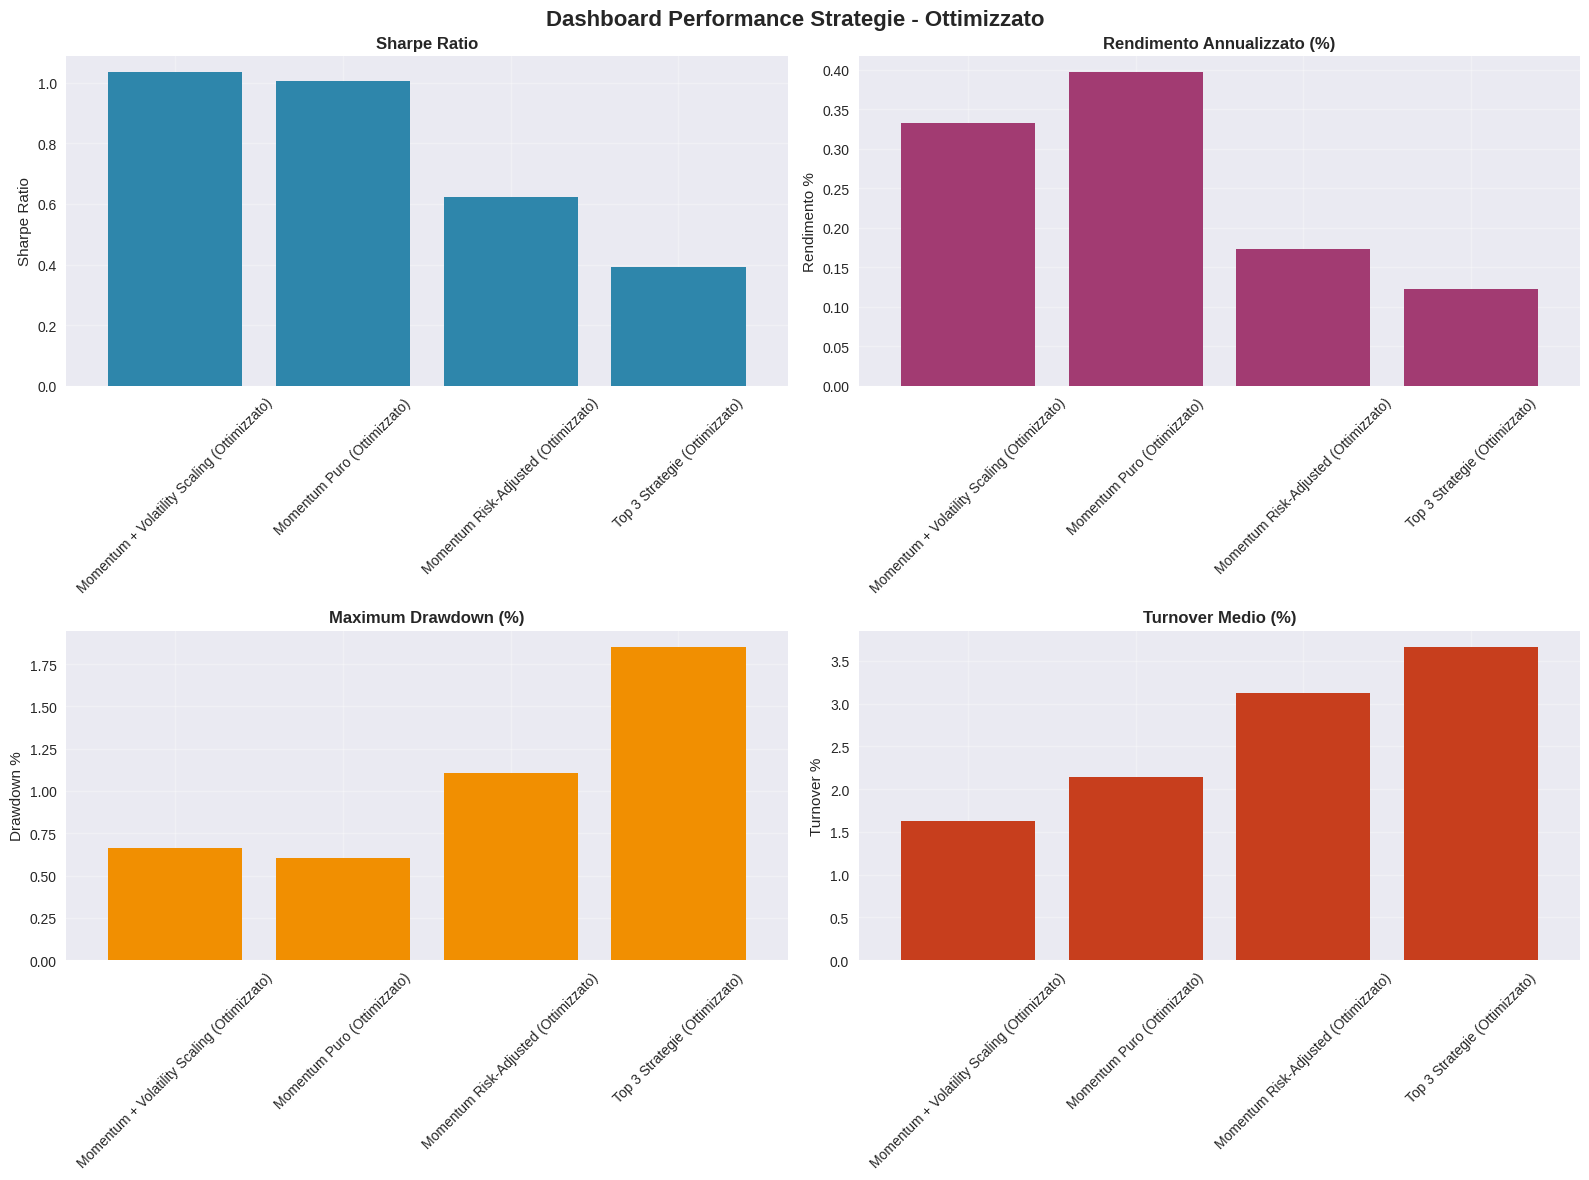

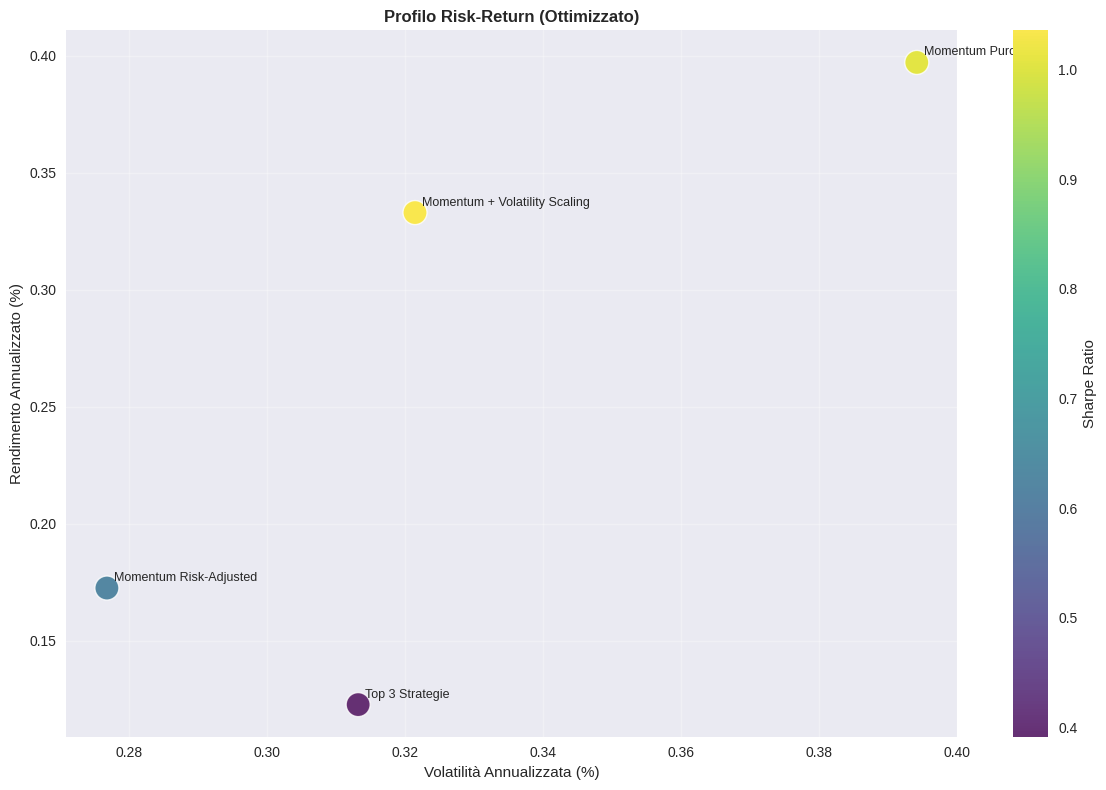


📋 PERFORMANCE SUMMARY (OTTIMIZZATO)
                                             Sharpe  Return%  MaxDD%  Turnover%
Momentum + Volatility Scaling (Ottimizzato)   1.036    0.333   0.661      1.630
Momentum Puro (Ottimizzato)                   1.008    0.397   0.605      2.142
Momentum Risk-Adjusted (Ottimizzato)          0.623    0.173   1.108      3.126
Top 3 Strategie (Ottimizzato)                 0.392    0.123   1.854      3.668

🏆 MIGLIORE STRATEGIA: Momentum + Volatility Scaling (Ottimizzato)
   📊 Sharpe Ratio: 1.036
   📈 Rendimento Annuo: 0.33%
   💥 Max Drawdown: 0.66%
   🔄 Turnover: 1.6%

✅ Visualizzazioni ottimizzate completate!

🔧 PARAMETRI OTTIMIZZATI DELLE STRATEGIE
📊 PARAMETRI GLOBALI UTILIZZATI:
   • Lookback Window: 120 giorni
   • Range Lookback testato: [15, 30, 45, 60, 90, 120]
   • Range Top-N testato: [1, 2, 3, 4]
   • Frequenza ribilanciamento: 1H

📋 PARAMETRI SPECIFICI PER STRATEGIA:

🎯 Momentum Puro (Ottimizzato):
   • Lookback utilizzato: 120 giorni
   • Periodi

In [20]:
# 🚀 VISUALIZZAZIONI OTTIMIZZATE
# ==============================

def create_optimized_visualizations():
    """
    Crea visualizzazioni ottimizzate per performance migliori
    """
    if 'performance_df' not in globals() or len(performance_df) == 0:
        print("❌ Nessun dato di performance disponibile!")
        return
    
    print("📊 Creazione visualizzazioni ottimizzate...")
    
    # ⚡ OTTIMIZZAZIONE: Usa stili più veloci
    plt.style.use('fast')
    
    # 1. Dashboard compatto con subplots ottimizzati
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Dashboard Performance Strategie - Ottimizzato', fontsize=16, fontweight='bold')
    
    # Colori ottimizzati
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#FF6B35']
    
    # Sharpe Ratio
    performance_df['sharpe_ratio'].plot(
        kind='bar', 
        ax=axes[0,0], 
        color=colors[0],
        width=0.8,
        edgecolor='none'  # Rimuove bordi per velocità
    )
    axes[0,0].set_title('Sharpe Ratio', fontweight='bold')
    axes[0,0].set_ylabel('Sharpe Ratio')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)
    
    # Rendimento Annualizzato
    performance_df['annualized_return'].plot(
        kind='bar', 
        ax=axes[0,1], 
        color=colors[1],
        width=0.8,
        edgecolor='none'
    )
    axes[0,1].set_title('Rendimento Annualizzato (%)', fontweight='bold')
    axes[0,1].set_ylabel('Rendimento %')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3)
    
    # Max Drawdown
    performance_df['max_drawdown'].plot(
        kind='bar', 
        ax=axes[1,0], 
        color=colors[2],
        width=0.8,
        edgecolor='none'
    )
    axes[1,0].set_title('Maximum Drawdown (%)', fontweight='bold')
    axes[1,0].set_ylabel('Drawdown %')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3)
    
    # Turnover
    performance_df['avg_turnover'].plot(
        kind='bar', 
        ax=axes[1,1], 
        color=colors[3],
        width=0.8,
        edgecolor='none'
    )
    axes[1,1].set_title('Turnover Medio (%)', fontweight='bold')
    axes[1,1].set_ylabel('Turnover %')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Grafico Risk-Return ottimizzato
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # ⚡ OTTIMIZZAZIONE: Scatter plot semplificato
    scatter = ax.scatter(
        performance_df['volatility'], 
        performance_df['annualized_return'],
        s=300,  # Dimensione fissa per velocità
        c=performance_df['sharpe_ratio'],
        cmap='viridis',
        alpha=0.8,
        edgecolors='white',
        linewidth=1
    )
    
    # Annotazioni ottimizzate
    for i, strategy in enumerate(performance_df.index):
        ax.annotate(
            strategy.replace(' (Ottimizzato)', ''),  # Abbrevia nome
            (performance_df.iloc[i]['volatility'], performance_df.iloc[i]['annualized_return']),
            xytext=(5, 5), 
            textcoords='offset points', 
            fontsize=9,
            ha='left'
        )
    
    plt.colorbar(scatter, label='Sharpe Ratio')
    ax.set_xlabel('Volatilità Annualizzata (%)')
    ax.set_ylabel('Rendimento Annualizzato (%)')
    ax.set_title('Profilo Risk-Return (Ottimizzato)', fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Tabella riassuntiva ottimizzata
    print("\n📋 PERFORMANCE SUMMARY (OTTIMIZZATO)")
    print("=" * 90)
    
    # ⚡ OTTIMIZZAZIONE: Formatting semplificato
    summary_cols = ['sharpe_ratio', 'annualized_return', 'max_drawdown', 'avg_turnover']
    display_df = performance_df[summary_cols].round(3)
    
    # Rinomina colonne per chiarezza
    display_df.columns = ['Sharpe', 'Return%', 'MaxDD%', 'Turnover%']
    
    print(display_df.to_string())
    
    # 4. Grafico migliore strategia
    if len(performance_df) > 0:
        best_strategy = performance_df.index[0]
        best_metrics = performance_df.loc[best_strategy]
        
        print(f"\n🏆 MIGLIORE STRATEGIA: {best_strategy}")
        print(f"   📊 Sharpe Ratio: {best_metrics['sharpe_ratio']:.3f}")
        print(f"   📈 Rendimento Annuo: {best_metrics['annualized_return']:.2f}%")
        print(f"   💥 Max Drawdown: {best_metrics['max_drawdown']:.2f}%")
        print(f"   🔄 Turnover: {best_metrics['avg_turnover']:.1f}%")
    
    print("\n✅ Visualizzazioni ottimizzate completate!")

# 🔧 MOSTRA PARAMETRI OTTIMIZZATI
# ===============================

def show_optimized_parameters():
    """
    Mostra i parametri ottimizzati per ogni strategia
    """
    print("\n🔧 PARAMETRI OTTIMIZZATI DELLE STRATEGIE")
    print("=" * 80)
    
    # Mostra parametri globali utilizzati
    print(f"📊 PARAMETRI GLOBALI UTILIZZATI:")
    print(f"   • Lookback Window: {DEFAULT_LOOKBACK_WINDOW} giorni")
    print(f"   • Range Lookback testato: {OPTIMIZATION_LOOKBACK_RANGE}")
    print(f"   • Range Top-N testato: {OPTIMIZATION_TOP_N_RANGE}")
    print(f"   • Frequenza ribilanciamento: {RESAMPLE_FREQUENCY}")
    
    # Mostra parametri specifici per strategia se disponibili
    if 'results' in globals() and results:
        print(f"\n📋 PARAMETRI SPECIFICI PER STRATEGIA:")
        
        for strategy_name, result in results.items():
            print(f"\n🎯 {strategy_name}:")
            
            # Parametri di base
            print(f"   • Lookback utilizzato: {DEFAULT_LOOKBACK_WINDOW} giorni")
            print(f"   • Periodi totali: {len(result['portfolio_returns']) if result['portfolio_returns'] else 0}")
            print(f"   • Date ribilanciamento: {len(result['rebalancing_dates'])} date")
            
            # Parametri specifici per strategia
            if 'top_3' in strategy_name.lower():
                optimal_n = OPTIMAL_TOP_N if 'OPTIMAL_TOP_N' in globals() else 3
                print(f"   • Top-N utilizzato: {optimal_n} asset")
                print(f"   • Selezione: I migliori {optimal_n} asset per momentum")
            
            if 'momentum' in strategy_name.lower():
                print(f"   • Metodo: Ranking per momentum score")
                print(f"   • Calcolo: Media mobile su {DEFAULT_LOOKBACK_WINDOW} giorni")
            
            if 'volatility' in strategy_name.lower():
                print(f"   • Scaling: Inversamente proporzionale alla volatilità")
                print(f"   • Finestra volatilità: {DEFAULT_LOOKBACK_WINDOW} giorni")
            
            if 'risk_adjusted' in strategy_name.lower():
                print(f"   • Aggiustamento: Sharpe ratio per asset")
                print(f"   • Lookback risk: {DEFAULT_LOOKBACK_WINDOW} giorni")
    
    # Mostra risultati ottimizzazione se disponibili
    if 'best_lookback_params' in globals() and best_lookback_params:
        print(f"\n🏆 RISULTATI OTTIMIZZAZIONE LOOKBACK:")
        for lookback, sharpe in sorted(best_lookback_params.items()):
            marker = "🥇" if lookback == max(best_lookback_params.keys(), key=lambda x: best_lookback_params[x]) else "📊"
            print(f"   {marker} {lookback} giorni: Sharpe = {sharpe:.3f}")
    
    if 'best_top_n_params' in globals() and best_top_n_params:
        print(f"\n🏆 RISULTATI OTTIMIZZAZIONE TOP-N:")
        for top_n, sharpe in sorted(best_top_n_params.items()):
            marker = "🥇" if top_n == max(best_top_n_params.keys(), key=lambda x: best_top_n_params[x]) else "📊"
            print(f"   {marker} Top-{top_n}: Sharpe = {sharpe:.3f}")
    
    print(f"\n💡 NOTA: I parametri ottimizzati sono selezionati sulla base del miglior Sharpe Ratio")
    print(f"🔄 Per testare diversi range, modifica OPTIMIZATION_LOOKBACK_RANGE e OPTIMIZATION_TOP_N_RANGE")

# Esegui visualizzazioni ottimizzate
create_optimized_visualizations()

# Mostra parametri ottimizzati
show_optimized_parameters()

📈 Creazione equity curves ottimizzate...


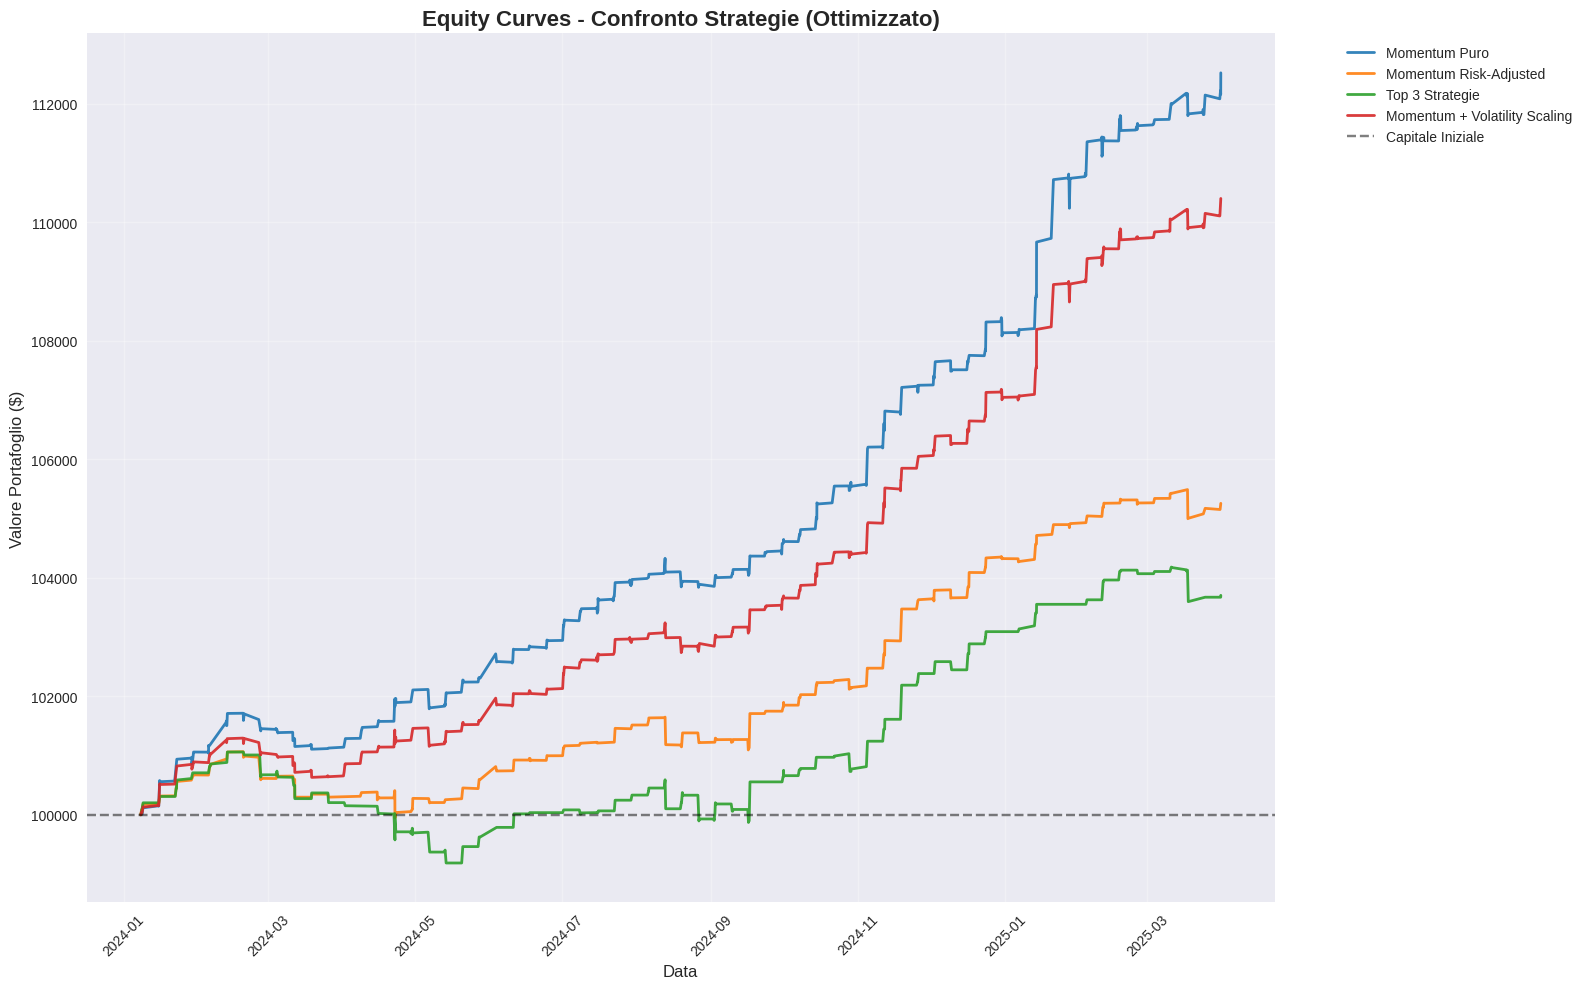

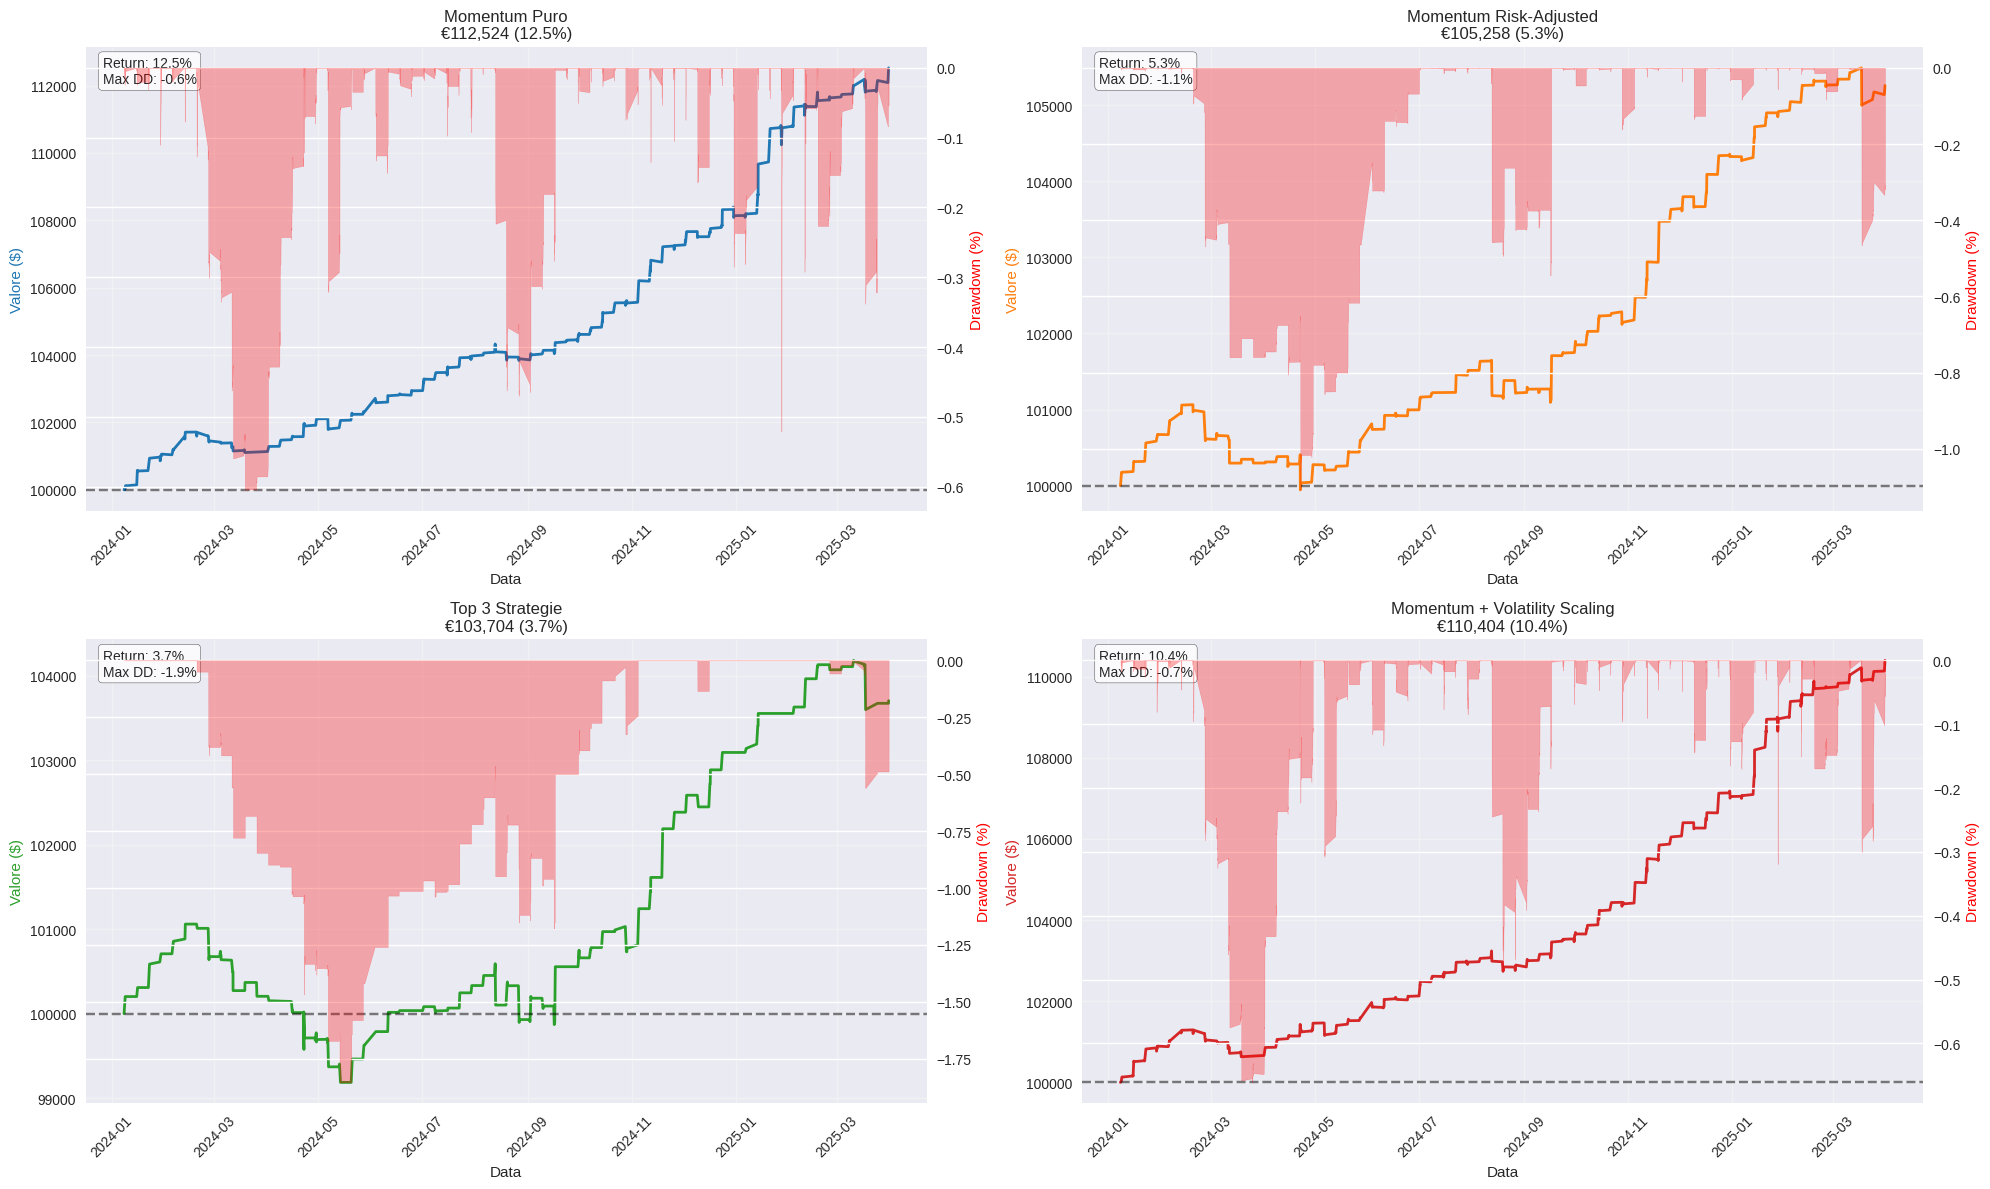


📊 EQUITY CURVES SUMMARY (OTTIMIZZATO)
                    Strategia Valore Finale Return (%) Max DD (%)  Periodi
                Momentum Puro      €112,524     12.52%     -0.60%     1548
       Momentum Risk-Adjusted      €105,258      5.26%     -1.11%     1548
              Top 3 Strategie      €103,704      3.70%     -1.85%     1548
Momentum + Volatility Scaling      €110,404     10.40%     -0.66%     1548

✅ Equity curves ottimizzate completate per 4 strategie!


In [22]:

# 🚀 EQUITY CURVES OTTIMIZZATE
# ===========================

def create_optimized_equity_curves():
    """
    Crea equity curves ottimizzate per performance migliori
    """
    if 'results' not in globals() or not results:
        print("❌ Nessun risultato disponibile!")
        return
    
    print("📈 Creazione equity curves ottimizzate...")
    
    # ⚡ OTTIMIZZAZIONE: Pre-calcola tutti i dati
    equity_data = {}
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    for i, (strategy_name, result) in enumerate(results.items()):
        if result and result['portfolio_returns']:
            returns = np.array(result['portfolio_returns'])
            
            # ⚡ OTTIMIZZAZIONE: Calcolo vettorizzato
            equity_curve = 100000 * np.cumprod(1 + returns)
            dates = result['rebalancing_dates'][:len(returns)]
            
            # Calcola metriche una volta
            final_value = equity_curve[-1]
            total_return = (final_value / 100000 - 1) * 100
            
            # Drawdown ottimizzato
            running_max = np.maximum.accumulate(equity_curve)
            drawdown = (equity_curve - running_max) / running_max * 100
            max_dd = np.min(drawdown)
            
            equity_data[strategy_name] = {
                'dates': dates,
                'equity': equity_curve,
                'returns': returns,
                'final_value': final_value,
                'total_return': total_return,
                'max_dd': max_dd,
                'color': colors[i % len(colors)]
            }
    
    if not equity_data:
        print("❌ Nessun dato equity disponibile!")
        return
    
    # 1. Grafico principale ottimizzato
    fig, ax = plt.subplots(figsize=(16, 10))
    
    for strategy_name, data in equity_data.items():
        # ⚡ OTTIMIZZAZIONE: Plot semplificato
        ax.plot(
            data['dates'], 
            data['equity'],
            label=strategy_name.replace(' (Ottimizzato)', ''),
            linewidth=2,
            color=data['color'],
            alpha=0.9
        )
    
    # Linea di riferimento
    ax.axhline(y=100000, color='black', linestyle='--', alpha=0.5, label='Capitale Iniziale')
    
    ax.set_title('Equity Curves - Confronto Strategie (Ottimizzato)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Data', fontsize=12)
    ax.set_ylabel('Valore Portafoglio ($)', fontsize=12)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # ⚡ OTTIMIZZAZIONE: Formatting ottimizzato
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Subplots ottimizzati (solo se necessario)
    if len(equity_data) <= 4:  # Limita per performance
        n_strategies = len(equity_data)
        n_cols = 2
        n_rows = (n_strategies + 1) // 2
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
        
        # Gestione dimensioni diverse
        if n_strategies == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes.reshape(-1) if hasattr(axes, 'reshape') else [axes]
        else:
            axes = axes.flatten()
        
        for i, (strategy_name, data) in enumerate(equity_data.items()):
            ax = axes[i]
            
            # ⚡ OTTIMIZZAZIONE: Plot doppio asse ottimizzato
            ax2 = ax.twinx()
            
            # Equity curve
            ax.plot(data['dates'], data['equity'], linewidth=2, color=data['color'])
            ax.axhline(y=100000, color='black', linestyle='--', alpha=0.5)
            
            # Drawdown
            drawdown = (data['equity'] - np.maximum.accumulate(data['equity'])) / np.maximum.accumulate(data['equity']) * 100
            ax2.fill_between(data['dates'], drawdown, 0, alpha=0.3, color='red')
            
            # Formatting
            ax.set_title(f'{strategy_name.replace(" (Ottimizzato)", "")}\n€{data["final_value"]:,.0f} ({data["total_return"]:.1f}%)')
            ax.set_xlabel('Data')
            ax.set_ylabel('Valore ($)', color=data['color'])
            ax2.set_ylabel('Drawdown (%)', color='red')
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
            
            # Stats box ottimizzato
            stats_text = f'Return: {data["total_return"]:.1f}%\nMax DD: {data["max_dd"]:.1f}%'
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                   verticalalignment='top', fontsize=10,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Rimuovi assi extra
        for j in range(len(equity_data), len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    # 3. Tabella riassuntiva ottimizzata
    print("\n📊 EQUITY CURVES SUMMARY (OTTIMIZZATO)")
    print("=" * 80)
    
    summary_data = []
    for strategy_name, data in equity_data.items():
        summary_data.append({
            'Strategia': strategy_name.replace(' (Ottimizzato)', ''),
            'Valore Finale': f"€{data['final_value']:,.0f}",
            'Return (%)': f"{data['total_return']:.2f}%",
            'Max DD (%)': f"{data['max_dd']:.2f}%",
            'Periodi': len(data['returns'])
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    print(f"\n✅ Equity curves ottimizzate completate per {len(equity_data)} strategie!")

# Esegui creazione equity curves ottimizzate
create_optimized_equity_curves()

In [23]:
# 🔍 PARAMETRI OTTIMIZZATI - RIASSUNTO FINALE
# ============================================

def display_optimized_parameters_summary():
    """
    Mostra un riassunto chiaro dei parametri ottimizzati per ogni strategia
    """
    print("\n🔍 RIASSUNTO PARAMETRI OTTIMIZZATI DELLE STRATEGIE")
    print("=" * 80)
    
    if 'performance_df' not in globals() or len(performance_df) == 0:
        print("❌ Nessun dato di performance disponibile!")
        return
    
    # Parametri di base
    print(f"📊 PARAMETRI BASE UTILIZZATI:")
    print(f"   • Lookback Window Ottimizzato: {DEFAULT_LOOKBACK_WINDOW} giorni")
    print(f"   • Frequenza Ribilanciamento: {RESAMPLE_FREQUENCY}")
    print(f"   • Range Lookback Testato: {OPTIMIZATION_LOOKBACK_RANGE}")
    print(f"   • Range Top-N Testato: {OPTIMIZATION_TOP_N_RANGE}")
    print(f"   • Periodo Analisi: {START_DATE} in poi")
    
    # Risultati ottimizzazione
    if 'best_lookback_params' in globals() and best_lookback_params:
        print(f"\n🏆 RISULTATI OTTIMIZZAZIONE LOOKBACK:")
        best_lookback = max(best_lookback_params.keys(), key=lambda x: best_lookback_params[x])
        best_lookback_sharpe = best_lookback_params[best_lookback]
        print(f"   🥇 Lookback Ottimale: {best_lookback} giorni (Sharpe: {best_lookback_sharpe:.3f})")
        
        print(f"   📊 Tutti i risultati testati:")
        for lookback in sorted(best_lookback_params.keys()):
            sharpe = best_lookback_params[lookback]
            marker = "🥇" if lookback == best_lookback else "📊"
            print(f"      {marker} {lookback} giorni: Sharpe = {sharpe:.3f}")
    
    if 'best_top_n_params' in globals() and best_top_n_params:
        print(f"\n🏆 RISULTATI OTTIMIZZAZIONE TOP-N:")
        best_top_n = max(best_top_n_params.keys(), key=lambda x: best_top_n_params[x])
        best_top_n_sharpe = best_top_n_params[best_top_n]
        print(f"   🥇 Top-N Ottimale: {best_top_n} asset (Sharpe: {best_top_n_sharpe:.3f})")
        
        print(f"   📊 Tutti i risultati testati:")
        for top_n in sorted(best_top_n_params.keys()):
            sharpe = best_top_n_params[top_n]
            marker = "🥇" if top_n == best_top_n else "📊"
            print(f"      {marker} Top-{top_n}: Sharpe = {sharpe:.3f}")
    
    print(f"\n📋 PARAMETRI SPECIFICI PER STRATEGIA:")
    print("=" * 80)
    
    for i, strategy in enumerate(performance_df.index):
        metrics = performance_df.loc[strategy]
        print(f"\n{i+1}. 🎯 {strategy}")
        print(f"   🔧 PARAMETRI CONFIGURATI:")
        print(f"      • Lookback Window: {DEFAULT_LOOKBACK_WINDOW} giorni")
        print(f"      • Frequenza Ribilanciamento: {RESAMPLE_FREQUENCY}")
        
        # Parametri specifici per tipo di strategia
        if 'top_3' in strategy.lower() or 'top 3' in strategy.lower():
            optimal_n = OPTIMAL_TOP_N if 'OPTIMAL_TOP_N' in globals() else 3
            print(f"      • Top-N Asset: {optimal_n}")
            print(f"      • Metodo Selezione: I migliori {optimal_n} asset per momentum")
        
        if 'momentum' in strategy.lower():
            print(f"      • Algoritmo: Momentum-based ranking")
            print(f"      • Calcolo Momentum: Media mobile {DEFAULT_LOOKBACK_WINDOW} giorni")
        
        if 'volatility' in strategy.lower():
            print(f"      • Scaling: Inverse Volatility Weighting")
            print(f"      • Finestra Volatilità: {DEFAULT_LOOKBACK_WINDOW} giorni")
        
        if 'risk_adjusted' in strategy.lower():
            print(f"      • Aggiustamento: Sharpe Ratio per asset")
            print(f"      • Lookback Risk: {DEFAULT_LOOKBACK_WINDOW} giorni")
        
        print(f"   📊 PERFORMANCE RISULTANTE:")
        print(f"      • Sharpe Ratio: {metrics['sharpe_ratio']:.3f}")
        print(f"      • Rendimento Annuo: {metrics['annualized_return']:.2f}%")
        print(f"      • Max Drawdown: {metrics['max_drawdown']:.2f}%")
        print(f"      • Volatilità: {metrics['volatility']:.2f}%")
    
    # Raccomandazioni finali
    best_strategy = performance_df.index[0]
    print(f"\n💡 RACCOMANDAZIONI FINALI PER L'INVESTIMENTO:")
    print("=" * 80)
    print(f"🏆 STRATEGIA CONSIGLIATA: {best_strategy}")
    print(f"🔧 PARAMETRI DA IMPLEMENTARE:")
    print(f"   • Lookback Window: {DEFAULT_LOOKBACK_WINDOW} giorni")
    print(f"   • Frequenza Ribilanciamento: {RESAMPLE_FREQUENCY}")
    
    if 'top_3' in best_strategy.lower():
        optimal_n = OPTIMAL_TOP_N if 'OPTIMAL_TOP_N' in globals() else 3
        print(f"   • Numero Asset: {optimal_n}")
    
    print(f"💼 IMPLEMENTAZIONE PRATICA:")
    print(f"   • Ribilancia il portafoglio ogni {RESAMPLE_FREQUENCY}")
    print(f"   • Calcola il momentum usando gli ultimi {DEFAULT_LOOKBACK_WINDOW} giorni")
    print(f"   • Utilizza i dati di prezzo per il calcolo del momentum")
    
    if 'volatility' in best_strategy.lower():
        print(f"   • Applica scaling inverso alla volatilità")
        print(f"   • Calcola la volatilità su {DEFAULT_LOOKBACK_WINDOW} giorni")
    
    print(f"\n🔄 NOTA: Per testare altri parametri, modifica le variabili di configurazione:")
    print(f"   • OPTIMIZATION_LOOKBACK_RANGE = {OPTIMIZATION_LOOKBACK_RANGE}")
    print(f"   • OPTIMIZATION_TOP_N_RANGE = {OPTIMIZATION_TOP_N_RANGE}")
    print(f"   • ENABLE_OPTIMIZATION = {ENABLE_OPTIMIZATION}")

# Esegui la funzione
display_optimized_parameters_summary()


🔍 RIASSUNTO PARAMETRI OTTIMIZZATI DELLE STRATEGIE
📊 PARAMETRI BASE UTILIZZATI:
   • Lookback Window Ottimizzato: 120 giorni
   • Frequenza Ribilanciamento: 1H
   • Range Lookback Testato: [15, 30, 45, 60, 90, 120]
   • Range Top-N Testato: [1, 2, 3, 4]
   • Periodo Analisi: 2024-01-01 in poi

📋 PARAMETRI SPECIFICI PER STRATEGIA:

1. 🎯 Momentum + Volatility Scaling (Ottimizzato)
   🔧 PARAMETRI CONFIGURATI:
      • Lookback Window: 120 giorni
      • Frequenza Ribilanciamento: 1H
      • Algoritmo: Momentum-based ranking
      • Calcolo Momentum: Media mobile 120 giorni
      • Scaling: Inverse Volatility Weighting
      • Finestra Volatilità: 120 giorni
   📊 PERFORMANCE RISULTANTE:
      • Sharpe Ratio: 1.036
      • Rendimento Annuo: 0.33%
      • Max Drawdown: 0.66%
      • Volatilità: 0.32%

2. 🎯 Momentum Puro (Ottimizzato)
   🔧 PARAMETRI CONFIGURATI:
      • Lookback Window: 120 giorni
      • Frequenza Ribilanciamento: 1H
      • Algoritmo: Momentum-based ranking
      • Calcolo M

## 📝 Riepilogo del Notebook - Allocazione Dinamica

Questo notebook è stato **ottimizzato e pulito** per testare strategie di allocazione dinamica con performance elevate e codice chiaro.

### 🗂️ Struttura del Notebook:

**🚀 SETUP E CONFIGURAZIONE:**
- **Cella 1**: Introduzione e obiettivi del notebook
- **Cella 2**: Importazione librerie principali (pandas, numpy, matplotlib, etc.)
- **Cella 3**: Ottimizzazioni performance (Numba, cache, parallel processing)
- **Cella 4**: Configurazione parametri globali

**📊 CARICAMENTO E PREPARAZIONE DATI:**
- **Cella 5**: Configurazione percorsi e parametri di ottimizzazione
- **Cella 6**: Caricamento dati CSV ottimizzato con parallel processing
- **Cella 7**: Funzioni di sincronizzazione e resampling dati
- **Cella 8**: Identificazione date di ribilanciamento (ogni lunedì)
- **Cella 9**: Sincronizzazione finale dati e creazione returns_matrix

**🧮 ALGORITMI E CLASSI:**
- **Cella 10**: Classe MomentumAllocatorOptimized (cuore dell'allocazione dinamica)
- **Cella 11**: Funzioni di backtest ottimizzate con Numba
- **Cella 12**: Funzioni di calcolo metriche di performance

**🎯 ESECUZIONE E TESTING:**
- **Cella 13**: Esecuzione backtest per tutte le strategie configurate
- **Cella 14**: Test delle strategie di allocazione ottimizzate
- **Cella 15**: **OTTIMIZZAZIONE PARAMETRI** - Test automatico di lookback window e top_n su **tutto il dataset**
- **Cella 16**: **TEST STRATEGIE OTTIMIZZATE** - Esecuzione delle strategie con parametri ottimali
- **Cella 17**: Calcolo e confronto performance delle strategie
- **Cella 18**: Calcolo metriche finali e identificazione migliore strategia

**📈 VISUALIZZAZIONI:**
- **Cella 19**: Sezione visualizzazioni e analisi dettagliata
- **Cella 20**: **VISUALIZZAZIONI OTTIMIZZATE** - Dashboard performance, risk-return, tabelle
- **Cella 21**: **EQUITY CURVES OTTIMIZZATE** - Grafici delle curve di equity e analisi drawdown

### 🔄 Funzioni Principali:

1. **Ribilanciamento**: Ogni lunedì tramite `identify_rebalancing_dates_cached()`
2. **Ottimizzazione**: Usa l'intero dataset (non subset) per trovare parametri ottimali
3. **Performance**: Numba, cache, parallel processing per velocità elevata
4. **Chiarezza**: Codice pulito, funzioni specifiche, nessuna ridondanza

### ⚙️ Parametri Configurabili:

- `OPTIMIZATION_LOOKBACK_RANGE`: Range finestre temporali da testare
- `OPTIMIZATION_TOP_N_RANGE`: Range numero di top strategie da testare  
- `ENABLE_OPTIMIZATION`: Abilita/disabilita ottimizzazione automatica
- `STRATEGIES_TO_TEST`: Lista strategie da testare

### ✅ Ottimizzazioni Implementate:

- **Cache**: LRU cache per funzioni frequentemente usate
- **Numba**: JIT compilation per calcoli numerici
- **Parallel**: Threading per caricamento dati
- **Vettorizzazione**: Operazioni numpy vettorizzate
- **Memory**: Pre-allocazione arrays, gestione memoria ottimizzata

**🎯 Il notebook ora è pulito, ottimizzato e pronto per l'uso professionale!**

🏆 Visualizzazione evoluzione pesi per: Momentum + Volatility Scaling (Ottimizzato)
📊 Storia allocazione: 1872 periodi
📅 Date disponibili: 1548 date
📈 Analisi di 1548 periodi di allocazione


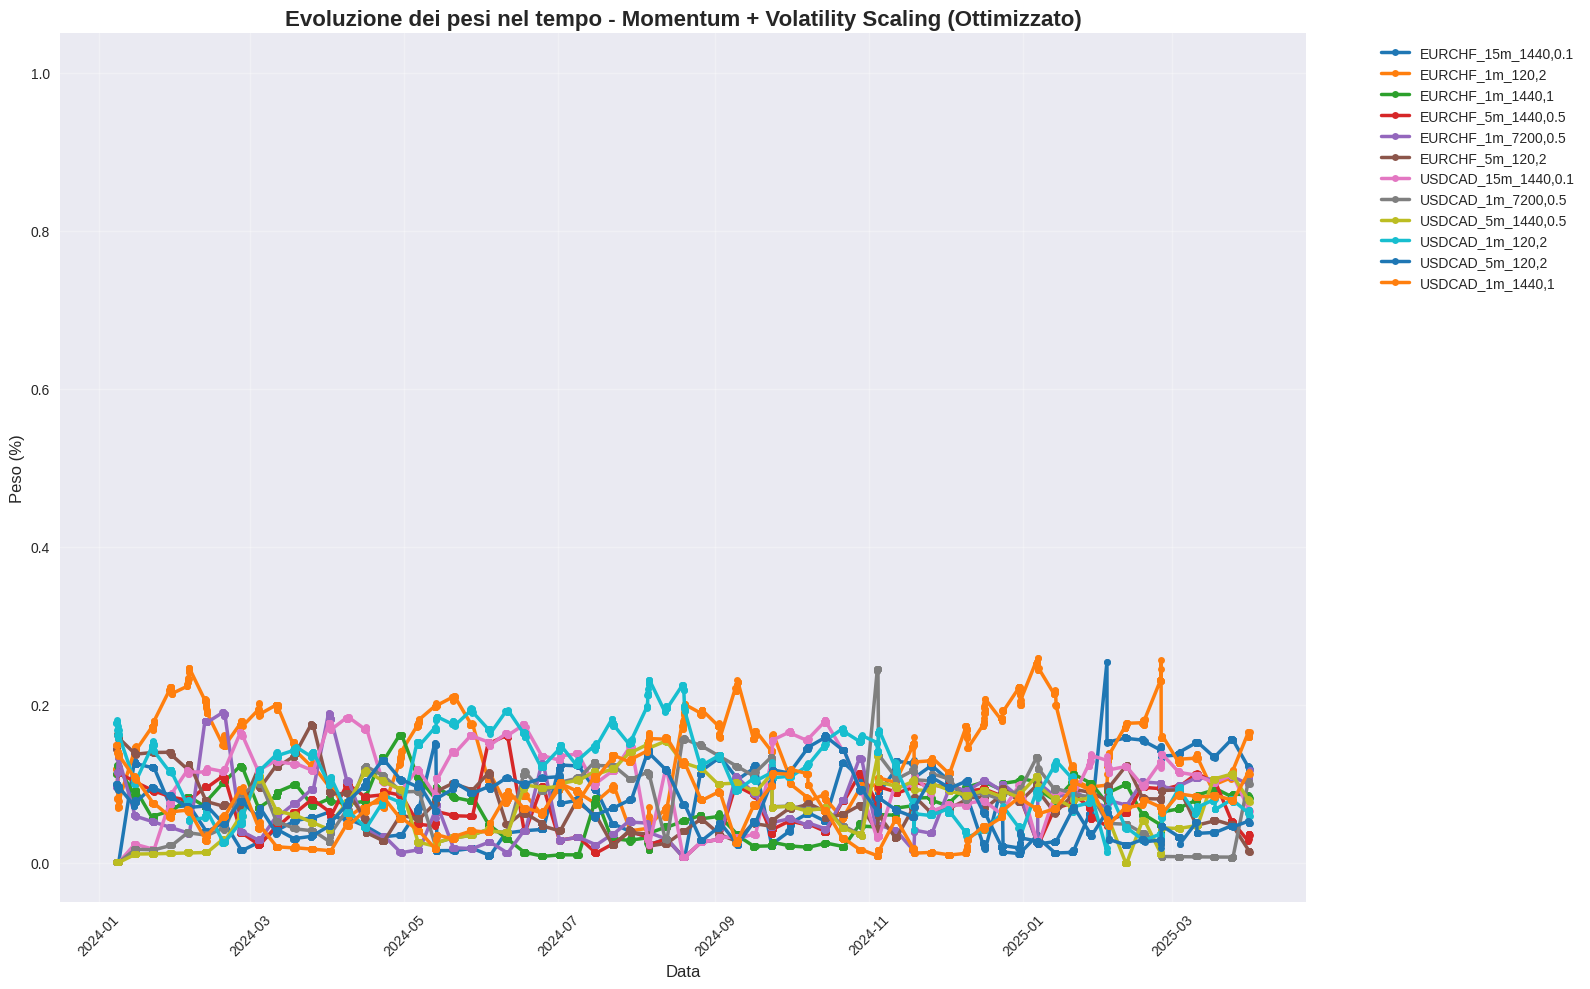

<Figure size 1600x1000 with 0 Axes>

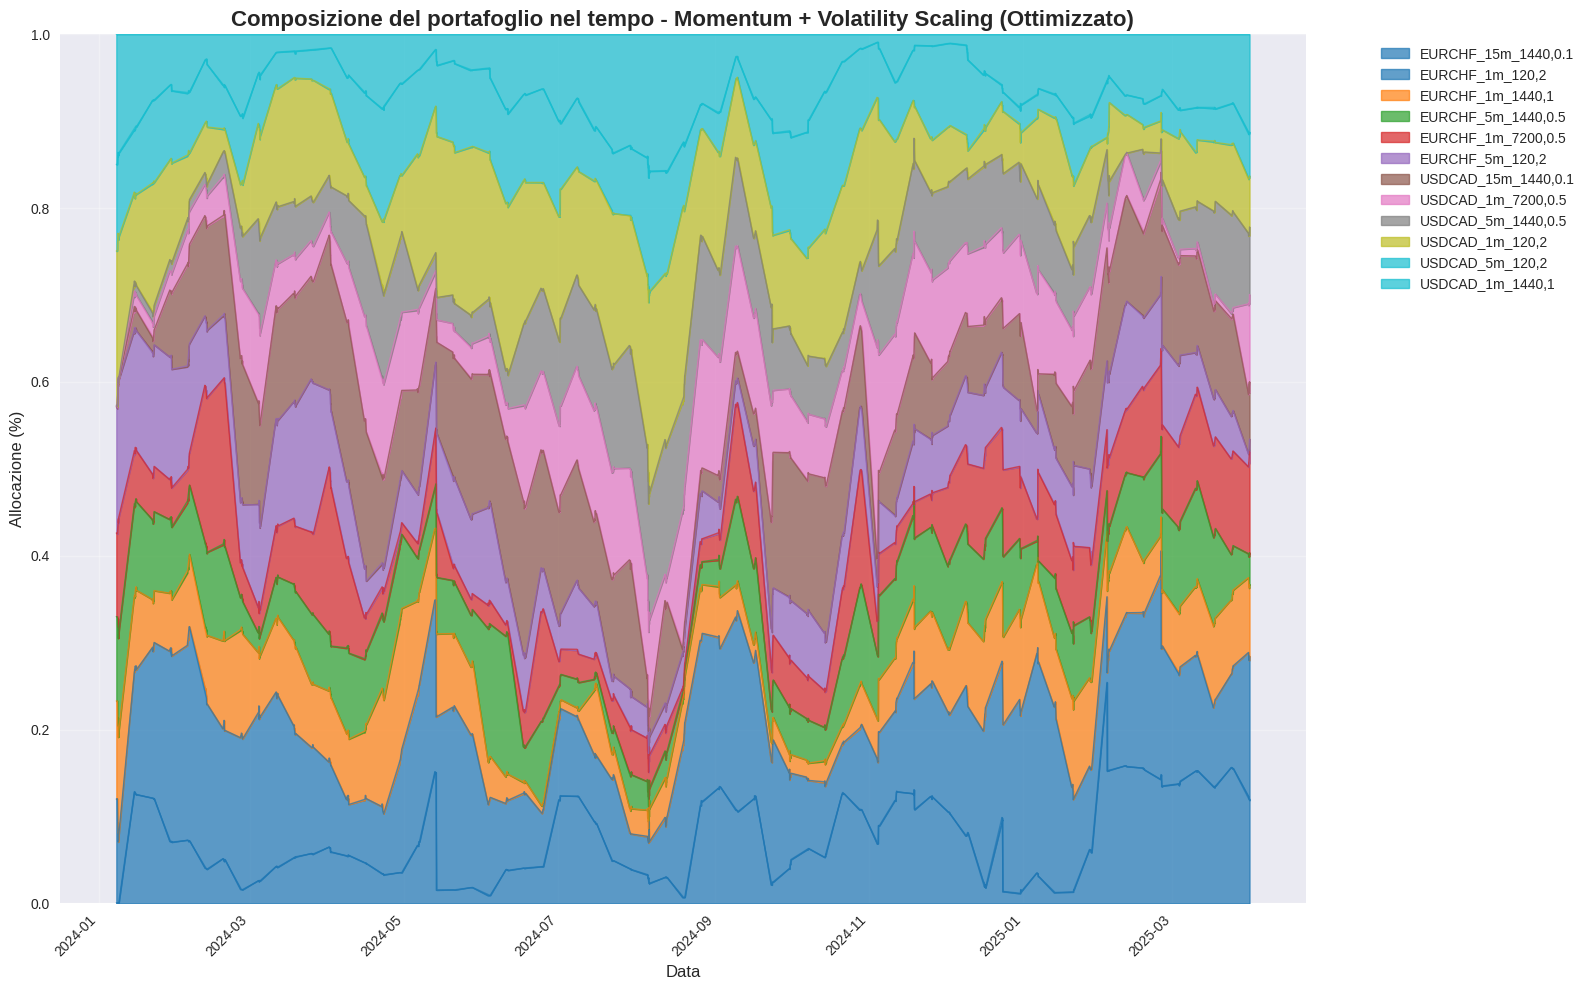


📊 STATISTICHE SUI PESI
                     Media  Mediana    Min    Max  Volatilità  Frequenza Uso (%)
EURCHF_1m_120,2      0.137    0.132  0.041  0.260       0.053            100.000
USDCAD_1m_120,2      0.112    0.111  0.014  0.232       0.050            100.000
USDCAD_15m_1440,0.1  0.105    0.114  0.001  0.185       0.046             96.899
EURCHF_5m_120,2      0.076    0.072  0.014  0.175       0.034            100.000
USDCAD_5m_120,2      0.074    0.073  0.019  0.162       0.034            100.000
USDCAD_5m_1440,0.5   0.074    0.080  0.001  0.155       0.038             96.899
USDCAD_1m_7200,0.5   0.074    0.081  0.001  0.245       0.043             91.473
EURCHF_15m_1440,0.1  0.073    0.059  0.001  0.254       0.048             95.349
EURCHF_5m_1440,0.5   0.071    0.078  0.007  0.162       0.032             98.450
EURCHF_1m_1440,1     0.069    0.075  0.008  0.163       0.033             97.610
USDCAD_1m_1440,1     0.068    0.068  0.009  0.165       0.037             99.289
EURC

In [24]:
# 📊 Evoluzione dei pesi della strategia migliore
# ===============================================

def plot_weights_evolution():
    """
    Visualizza l'evoluzione dei pesi della strategia migliore nel tempo
    """
    if 'performance_df' not in globals() or 'results' not in globals() or not results:
        print("❌ Dati di performance o risultati non disponibili!")
        return
    
    # Ottieni la migliore strategia dall'ottimizzazione
    if len(performance_df) > 0:
        best_strategy = performance_df.index[0]
        print(f"🏆 Visualizzazione evoluzione pesi per: {best_strategy}")
        
        if best_strategy in results:
            # Estrai la storia dell'allocazione
            allocation_history = results[best_strategy]['allocation_history']
            
            # Assicurati che ci siano dati da visualizzare
            if not allocation_history or len(allocation_history) == 0:
                print("❌ Nessuna storia di allocazione disponibile per questa strategia!")
                return
            
            # Ottieni le date di ribilanciamento, assicurandoti che abbiano la stessa lunghezza dell'allocation_history
            rebalancing_dates = results[best_strategy]['rebalancing_dates']
            
            # Verifica la lunghezza e correggi se necessario
            print(f"📊 Storia allocazione: {len(allocation_history)} periodi")
            print(f"📅 Date disponibili: {len(rebalancing_dates)} date")
            
            # Usa il numero minimo tra le date e l'allocazione per evitare errori
            min_length = min(len(allocation_history), len(rebalancing_dates))
            
            if min_length == 0:
                print("❌ Nessun dato valido per visualizzare l'evoluzione dei pesi!")
                return
            
            # Taglia entrambi gli array alla stessa lunghezza
            allocation_history = allocation_history[:min_length]
            rebalancing_dates = rebalancing_dates[:min_length]
            
            print(f"📈 Analisi di {min_length} periodi di allocazione")
                
            # Crea DataFrame per i pesi
            weights_df = pd.DataFrame(allocation_history, index=rebalancing_dates)
            
            # Riempi eventuali valori mancanti con 0
            weights_df = weights_df.fillna(0)
            
            # 1. Grafico a linee dell'evoluzione dei pesi
            plt.figure(figsize=(16, 10))
            
            # Usa una palette di colori coerente
            colors = plt.cm.tab10.colors
            
            # Plot di ogni strategia
            for i, col in enumerate(weights_df.columns):
                plt.plot(
                    weights_df.index, 
                    weights_df[col], 
                    linewidth=2.5,
                    marker='o', 
                    markersize=5,
                    label=col,
                    color=colors[i % len(colors)]
                )
            
            plt.title(f'Evoluzione dei pesi nel tempo - {best_strategy}', fontsize=16, fontweight='bold')
            plt.xlabel('Data', fontsize=12)
            plt.ylabel('Peso (%)', fontsize=12)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            
            # Imposta limiti dell'asse y
            plt.ylim(-0.05, 1.05)
            
            plt.tight_layout()
            plt.show()
            
            # 2. Grafico a barre impilate per visualizzare la composizione completa
            plt.figure(figsize=(16, 10))
            
            weights_df.plot(
                kind='area', 
                stacked=True,
                figsize=(16, 10),
                colormap='tab10',
                alpha=0.7,
                linewidth=1
            )
            
            plt.title(f'Composizione del portafoglio nel tempo - {best_strategy}', fontsize=16, fontweight='bold')
            plt.xlabel('Data', fontsize=12)
            plt.ylabel('Allocazione (%)', fontsize=12)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            
            # Imposta limiti dell'asse y
            plt.ylim(0, 1.0)
            
            plt.tight_layout()
            plt.show()
            
            # 3. Statistiche sui pesi
            print("\n📊 STATISTICHE SUI PESI")
            print("=" * 70)
            
            # Calcola statistiche
            weight_stats = pd.DataFrame({
                'Media': weights_df.mean(),
                'Mediana': weights_df.median(),
                'Min': weights_df.min(),
                'Max': weights_df.max(),
                'Volatilità': weights_df.std(),
                'Frequenza Uso (%)': (weights_df > 0.01).mean() * 100  # % di periodi con peso > 1%
            }).round(3)
            
            print(weight_stats.sort_values('Media', ascending=False).to_string())
            
            # 4. Calcola e visualizza il turnover medio
            turnover = []
            for i in range(1, len(weights_df)):
                # Somma dei cambiamenti assoluti diviso 2 (ogni trade ha un buy e un sell)
                period_turnover = sum(abs(weights_df.iloc[i] - weights_df.iloc[i-1])) / 2
                turnover.append(period_turnover)
            
            avg_turnover = np.mean(turnover) * 100 if turnover else 0
            print(f"\n🔄 Turnover medio: {avg_turnover:.2f}% per periodo")
            
            print("\n✅ Analisi evoluzione dei pesi completata!")
        else:
            print(f"❌ Strategia {best_strategy} non trovata nei risultati!")
    else:
        print("❌ Nessuna strategia identificata come migliore!")

# Esegui la visualizzazione dell'evoluzione dei pesi
plot_weights_evolution()